# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
filename = 'hoasa-random'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service', 'sunrise_meal', 'tv', 'wifi']
aspect_mapping = {'ac': 0, 'air_panas': 1, 'bau': 2, 'general': 3, 'kebersihan': 4, 'linen': 5, 'service': 6, 'sunrise_meal': 7, 'tv': 8, 'wifi': 9}
label_mapping = {"neg": 0, "neut": 1, 'neg_pos': 1, 'pos': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/hoasa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/hoasa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/hoasa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['review'].values
y_train = train_data[train_labels].values
X_val = val_data['review'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2283,) (2283, 10)
(571,) (571, 10)


# BUILD DATASET & DATALOADERS

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [11]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [12]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [14]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 50

In [15]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [16]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [17]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            aspect_list,
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [18]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend(random_indices)
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'ac': [y_train[i][0] for i in temp],
            'air_panas': [y_train[i][1] for i in temp],
            'bau': [y_train[i][2] for i in temp],
            'general': [y_train[i][3] for i in temp],
            'kebersihan': [y_train[i][4] for i in temp],
            'linen': [y_train[i][5] for i in temp],
            'service': [y_train[i][6] for i in temp],
            'sunrise_meal': [y_train[i][7] for i in temp],
            'tv': [y_train[i][8] for i in temp],
            'wifi': [y_train[i][9] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [20]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed
        )
        notebook_launcher(train_model, args, num_processes=2)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        random_sampling(
            current_train_size, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i
        )
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [21]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5865, Accuracy: 0.7995, F1 Micro: 0.8876, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4747, Accuracy: 0.801, F1 Micro: 0.8892, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4337, Accuracy: 0.8007, F1 Micro: 0.8893, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.425, Accuracy: 0.8033, F1 Micro: 0.8905, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4065, Accuracy: 0.8064, F1 Micro: 0.8916, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4121, Accuracy: 0.8101, F1 Micro: 0.8933, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3857, Accuracy: 0.8177, F1 Micro: 0.8971, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3725, Accuracy: 0.8321, F1 Micro: 0.9044, F1 Macro: 0.8994
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6014, Accuracy: 0.6293, F1 Micro: 0.6293, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5503, Accuracy: 0.6293, F1 Micro: 0.6293, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4934, Accuracy: 0.6293, F1 Micro: 0.6293, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3898, Accuracy: 0.6878, F1 Micro: 0.6878, F1 Macro: 0.5444
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3441, Accuracy: 0.7488, F1 Micro: 0.7488, F1 Macro: 0.6959
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2311, Accuracy: 0.7634, F1 Micro: 0.7634, F1 Macro: 0.719
Epoch 7/10, Train Loss: 0.181, Accuracy: 0.7439, F1 Micro: 0.7439, F1 Macro: 0.6915
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2402, Accuracy: 0.7756, F1 Micro: 0.7756, F1 Macro: 0.7399
Epoch 9/10, Train Loss: 0.1526, Accuracy: 0.7512, F1 Micro: 0.7512, F1 Macro: 0.6996
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5476, Accuracy: 0.8033, F1 Micro: 0.8902, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4712, Accuracy: 0.8038, F1 Micro: 0.8908, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4386, Accuracy: 0.8189, F1 Micro: 0.8979, F1 Macro: 0.8925
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.404, Accuracy: 0.8458, F1 Micro: 0.9113, F1 Macro: 0.907
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3525, Accuracy: 0.8714, F1 Micro: 0.9247, F1 Macro: 0.9208
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2998, Accuracy: 0.8901, F1 Micro: 0.9349, F1 Macro: 0.9318
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2574, Accuracy: 0.905, F1 Micro: 0.9431, F1 Macro: 0.9405
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2257, Accuracy: 0.9111, F1 Micro: 0.9463, F1 Macro: 0.9433
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5097, Accuracy: 0.7629, F1 Micro: 0.7629, F1 Macro: 0.4327
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4266, Accuracy: 0.794, F1 Micro: 0.794, F1 Macro: 0.5695
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3152, Accuracy: 0.824, F1 Micro: 0.824, F1 Macro: 0.7067
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2747, Accuracy: 0.8383, F1 Micro: 0.8383, F1 Macro: 0.7814
Epoch 5/10, Train Loss: 0.2467, Accuracy: 0.812, F1 Micro: 0.812, F1 Macro: 0.7629
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2119, Accuracy: 0.8683, F1 Micro: 0.8683, F1 Macro: 0.7932
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2042, Accuracy: 0.879, F1 Micro: 0.879, F1 Macro: 0.8062
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1569, Accuracy: 0.8802, F1 Micro: 0.8802, F1 Macro: 0.8076
Epoch 9/10, Train Loss: 0.1338, Accuracy: 0.8778, F1 Micro: 0.8778, F1 Macro: 0.8222
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5065, Accuracy: 0.8019, F1 Micro: 0.8899, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4407, Accuracy: 0.8266, F1 Micro: 0.9015, F1 Macro: 0.8964
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.392, Accuracy: 0.8611, F1 Micro: 0.9197, F1 Macro: 0.9164
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3291, Accuracy: 0.8903, F1 Micro: 0.9351, F1 Macro: 0.9322
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2594, Accuracy: 0.9016, F1 Micro: 0.9414, F1 Macro: 0.9388
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2294, Accuracy: 0.9271, F1 Micro: 0.9558, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.199, Accuracy: 0.9306, F1 Micro: 0.9579, F1 Macro: 0.9556
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1738, Accuracy: 0.9349, F1 Micro: 0.9604, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4532, Accuracy: 0.7627, F1 Micro: 0.7627, F1 Macro: 0.5367
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3418, Accuracy: 0.8218, F1 Micro: 0.8218, F1 Macro: 0.7226
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2429, Accuracy: 0.8528, F1 Micro: 0.8528, F1 Macro: 0.8053
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.215, Accuracy: 0.8767, F1 Micro: 0.8767, F1 Macro: 0.8304
Epoch 5/10, Train Loss: 0.1721, Accuracy: 0.8601, F1 Micro: 0.8601, F1 Macro: 0.7843
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1691, Accuracy: 0.8933, F1 Micro: 0.8933, F1 Macro: 0.8537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1461, Accuracy: 0.8933, F1 Micro: 0.8933, F1 Macro: 0.8523
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1237, Accuracy: 0.8995, F1 Micro: 0.8995, F1 Macro: 0.8592
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.9026, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5047, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4196, Accuracy: 0.8413, F1 Micro: 0.9094, F1 Macro: 0.9057
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3485, Accuracy: 0.8847, F1 Micro: 0.9322, F1 Macro: 0.9295
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2724, Accuracy: 0.9135, F1 Micro: 0.9482, F1 Macro: 0.9458
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2261, Accuracy: 0.9262, F1 Micro: 0.9554, F1 Macro: 0.953
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1912, Accuracy: 0.9342, F1 Micro: 0.96, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1724, Accuracy: 0.9387, F1 Micro: 0.9627, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1461, Accuracy: 0.9451, F1 Micro: 0.9664, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4675, Accuracy: 0.8171, F1 Micro: 0.8171, F1 Macro: 0.7446
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2704, Accuracy: 0.8499, F1 Micro: 0.8499, F1 Macro: 0.8068
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2166, Accuracy: 0.8648, F1 Micro: 0.8648, F1 Macro: 0.8275
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1554, Accuracy: 0.8877, F1 Micro: 0.8877, F1 Macro: 0.8522
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.8728, F1 Micro: 0.8728, F1 Macro: 0.8132
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8624
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.8986, F1 Micro: 0.8986, F1 Macro: 0.8567
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8671
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.059, Accuracy: 0.9095, F1 Micro: 0.9095, F1 Macro: 0.8767
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4982, Accuracy: 0.8016, F1 Micro: 0.8898, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4091, Accuracy: 0.871, F1 Micro: 0.9243, F1 Macro: 0.9205
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3133, Accuracy: 0.9078, F1 Micro: 0.9451, F1 Macro: 0.9427
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.243, Accuracy: 0.9295, F1 Micro: 0.9574, F1 Macro: 0.9554
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1997, Accuracy: 0.9356, F1 Micro: 0.9608, F1 Macro: 0.9586
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1697, Accuracy: 0.941, F1 Micro: 0.9641, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1475, Accuracy: 0.9469, F1 Micro: 0.9675, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1278, Accuracy: 0.9476, F1 Micro: 0.9679, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4612, Accuracy: 0.8495, F1 Micro: 0.8495, F1 Macro: 0.8042
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2664, Accuracy: 0.8628, F1 Micro: 0.8628, F1 Macro: 0.8273
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2397, Accuracy: 0.8639, F1 Micro: 0.8639, F1 Macro: 0.7913
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.12, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8756
Epoch 6/10, Train Loss: 0.0964, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8693
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0623, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8774
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.8925, F1 Micro: 0.8925, F1 Macro: 0.8421
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8843
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4904, Accuracy: 0.8035, F1 Micro: 0.8907, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3951, Accuracy: 0.8783, F1 Micro: 0.9287, F1 Macro: 0.9253
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2998, Accuracy: 0.9122, F1 Micro: 0.9476, F1 Macro: 0.9455
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2264, Accuracy: 0.9361, F1 Micro: 0.9611, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1948, Accuracy: 0.942, F1 Micro: 0.9646, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1583, Accuracy: 0.9441, F1 Micro: 0.9659, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1331, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1146, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3908, Accuracy: 0.8506, F1 Micro: 0.8506, F1 Macro: 0.8037
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2397, Accuracy: 0.8535, F1 Micro: 0.8535, F1 Macro: 0.8189
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2197, Accuracy: 0.8934, F1 Micro: 0.8934, F1 Macro: 0.8631
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1302, Accuracy: 0.8934, F1 Micro: 0.8934, F1 Macro: 0.8546
Epoch 5/10, Train Loss: 0.0872, Accuracy: 0.8896, F1 Micro: 0.8896, F1 Macro: 0.8474
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0704, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.884
Epoch 7/10, Train Loss: 0.0636, Accuracy: 0.8982, F1 Micro: 0.8982, F1 Macro: 0.8613
Epoch 8/10, Train Loss: 0.0524, Accuracy: 0.8944, F1 Micro: 0.8944, F1 Macro: 0.855
Epoch 9/10, Train Loss: 0.0263, Accuracy: 0.8953, F1 Micro: 0.8953, F1 Macro: 0.8565
Epoch 10/10, Train Loss: 0.0327, Accuracy: 0.9077, F1 Micro: 0.9077, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4883, Accuracy: 0.8056, F1 Micro: 0.8917, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.361, Accuracy: 0.8911, F1 Micro: 0.9355, F1 Macro: 0.9325
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2714, Accuracy: 0.9288, F1 Micro: 0.957, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2126, Accuracy: 0.9406, F1 Micro: 0.9637, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1802, Accuracy: 0.9411, F1 Micro: 0.9641, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1474, Accuracy: 0.95, F1 Micro: 0.9693, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1259, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.9699
Epoch 8/10, Train Loss: 0.1124, Accuracy: 0.954, F1 Micro: 0.9717, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0948, Accuracy: 0.95

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4459, Accuracy: 0.8151, F1 Micro: 0.8151, F1 Macro: 0.7881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2656, Accuracy: 0.8736, F1 Micro: 0.8736, F1 Macro: 0.8269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1986, Accuracy: 0.8975, F1 Micro: 0.8975, F1 Macro: 0.8639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1272, Accuracy: 0.8975, F1 Micro: 0.8975, F1 Macro: 0.8628
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1165, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8929
Epoch 7/10, Train Loss: 0.0463, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8774
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0366, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.8979
Epoch 9/10, Train Loss: 0.0301, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.88
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.474, Accuracy: 0.8257, F1 Micro: 0.9016, F1 Macro: 0.8972
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3469, Accuracy: 0.9, F1 Micro: 0.9404, F1 Macro: 0.9379
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2489, Accuracy: 0.9323, F1 Micro: 0.9588, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1922, Accuracy: 0.9432, F1 Micro: 0.9653, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1627, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1363, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1131, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.0984, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9726
Epoch 9/10, Train Loss: 0.0848, Accuracy: 0.9575, F1 Micro: 0.9738, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4212, Accuracy: 0.856, F1 Micro: 0.856, F1 Macro: 0.8208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2218, Accuracy: 0.8651, F1 Micro: 0.8651, F1 Macro: 0.8193
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1818, Accuracy: 0.9018, F1 Micro: 0.9018, F1 Macro: 0.8739
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1384, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0875, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8859
Epoch 6/10, Train Loss: 0.0638, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8836
Epoch 7/10, Train Loss: 0.0581, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8817
Epoch 8/10, Train Loss: 0.0459, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8779
Epoch 9/10, Train Loss: 0.0339, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.02, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.475, Accuracy: 0.8299, F1 Micro: 0.9035, F1 Macro: 0.8987
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3395, Accuracy: 0.9083, F1 Micro: 0.9453, F1 Macro: 0.9427
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2376, Accuracy: 0.9375, F1 Micro: 0.9621, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1891, Accuracy: 0.9483, F1 Micro: 0.9683, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1533, Accuracy: 0.9497, F1 Micro: 0.9692, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1303, Accuracy: 0.9575, F1 Micro: 0.9738, F1 Macro: 0.9715
Epoch 7/10, Train Loss: 0.1096, Accuracy: 0.9571, F1 Micro: 0.9736, F1 Macro: 0.9714
Epoch 8/10, Train Loss: 0.0939, Accuracy: 0.9571, F1 Micro: 0.9736, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0801, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4036, Accuracy: 0.859, F1 Micro: 0.859, F1 Macro: 0.8175
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.232, Accuracy: 0.8822, F1 Micro: 0.8822, F1 Macro: 0.8405
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1614, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0972, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.072, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8889
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0718, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8869
Epoch 7/10, Train Loss: 0.0585, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.9212, F1 Micro: 0.9212, F1 Macro: 0.8988
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8866
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.473, Accuracy: 0.8438, F1 Micro: 0.9104, F1 Macro: 0.9065
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3306, Accuracy: 0.904, F1 Micro: 0.9429, F1 Macro: 0.9406
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2297, Accuracy: 0.9384, F1 Micro: 0.9623, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1805, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1502, Accuracy: 0.9519, F1 Micro: 0.9705, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1256, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1059, Accuracy: 0.9564, F1 Micro: 0.9732, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0914, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.388, Accuracy: 0.8326, F1 Micro: 0.8326, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.247, Accuracy: 0.8705, F1 Micro: 0.8705, F1 Macro: 0.8246
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1631, Accuracy: 0.8751, F1 Micro: 0.8751, F1 Macro: 0.8241
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1366, Accuracy: 0.8964, F1 Micro: 0.8964, F1 Macro: 0.8621
Epoch 5/10, Train Loss: 0.0914, Accuracy: 0.8936, F1 Micro: 0.8936, F1 Macro: 0.8561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0738, Accuracy: 0.9019, F1 Micro: 0.9019, F1 Macro: 0.8711
Epoch 7/10, Train Loss: 0.037, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8673
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.8945, F1 Micro: 0.8945, F1 Macro: 0.8564
Epoch 9/10, Train Loss: 0.0243, Accuracy: 0.8945, F1 Micro: 0.8945, F1 Macro: 0.8596
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.8992, F1 Micro: 0.8992, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.465, Accuracy: 0.845, F1 Micro: 0.9107, F1 Macro: 0.9062
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3168, Accuracy: 0.9205, F1 Micro: 0.9523, F1 Macro: 0.9497
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.9422, F1 Micro: 0.9647, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1777, Accuracy: 0.9498, F1 Micro: 0.9692, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.148, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9718
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9573, F1 Micro: 0.9737, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1025, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0857, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0735, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9731
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3743, Accuracy: 0.8633, F1 Micro: 0.8633, F1 Macro: 0.8237
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.231, Accuracy: 0.8989, F1 Micro: 0.8989, F1 Macro: 0.8708
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.161, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8843
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.098, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8832
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0865, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0579, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8882
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0435, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.8928
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8871
Epoch 9/10, Train Loss: 0.0178, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8874
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4665, Accuracy: 0.8521, F1 Micro: 0.9139, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3112, Accuracy: 0.9194, F1 Micro: 0.9516, F1 Macro: 0.9488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2283, Accuracy: 0.9392, F1 Micro: 0.9631, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1743, Accuracy: 0.9505, F1 Micro: 0.9697, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1243, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1049, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9743
Epoch 8/10, Train Loss: 0.0871, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3896, Accuracy: 0.8543, F1 Micro: 0.8543, F1 Macro: 0.8169
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2527, Accuracy: 0.8752, F1 Micro: 0.8752, F1 Macro: 0.836
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1612, Accuracy: 0.8998, F1 Micro: 0.8998, F1 Macro: 0.87
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1139, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8742
Epoch 5/10, Train Loss: 0.0931, Accuracy: 0.9007, F1 Micro: 0.9007, F1 Macro: 0.8698
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.064, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8731
Epoch 7/10, Train Loss: 0.054, Accuracy: 0.8998, F1 Micro: 0.8998, F1 Macro: 0.8731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0424, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8821
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.033, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8844
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4588, Accuracy: 0.8595, F1 Micro: 0.9179, F1 Macro: 0.9124
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.309, Accuracy: 0.9219, F1 Micro: 0.9529, F1 Macro: 0.9505
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2169, Accuracy: 0.9394, F1 Micro: 0.9632, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1182, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9747
Epoch 8/10, Train Loss: 0.0851, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.0706, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3806, Accuracy: 0.8707, F1 Micro: 0.8707, F1 Macro: 0.8378
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2266, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8635
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1626, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8886
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1163, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.8887
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0785, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9012
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0577, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9037
Epoch 7/10, Train Loss: 0.0418, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8689
Epoch 8/10, Train Loss: 0.0425, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.8964
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8882
Epoch 10/10, Train Loss: 0.0252, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4528, Accuracy: 0.8628, F1 Micro: 0.9201, F1 Macro: 0.9154
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2996, Accuracy: 0.9286, F1 Micro: 0.9567, F1 Macro: 0.954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2158, Accuracy: 0.9476, F1 Micro: 0.9678, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1364, Accuracy: 0.9563, F1 Micro: 0.9731, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.975
Epoch 8/10, Train Loss: 0.0793, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0685, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3688, Accuracy: 0.8583, F1 Micro: 0.8583, F1 Macro: 0.807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.241, Accuracy: 0.9019, F1 Micro: 0.9019, F1 Macro: 0.8682
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.157, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8731
Epoch 4/10, Train Loss: 0.1076, Accuracy: 0.9009, F1 Micro: 0.9009, F1 Macro: 0.8643
Epoch 5/10, Train Loss: 0.0733, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8687
Epoch 6/10, Train Loss: 0.0528, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0524, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.884
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8723
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.88
Epoch 10/10, Train Loss: 0.0293, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8734

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4504, Accuracy: 0.8608, F1 Micro: 0.9191, F1 Macro: 0.9151
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2875, Accuracy: 0.9339, F1 Micro: 0.9596, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2037, Accuracy: 0.9465, F1 Micro: 0.9673, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1591, Accuracy: 0.9557, F1 Micro: 0.9727, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.9573, F1 Micro: 0.9737, F1 Macro: 0.9711
Epoch 6/10, Train Loss: 0.1112, Accuracy: 0.9563, F1 Micro: 0.9731, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.974
Epoch 8/10, Train Loss: 0.0802, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.962, F1 Micro: 0.9765, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.357, Accuracy: 0.86, F1 Micro: 0.86, F1 Macro: 0.8285
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2061, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8674
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1576, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1137, Accuracy: 0.9224, F1 Micro: 0.9224, F1 Macro: 0.8968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0854, Accuracy: 0.9224, F1 Micro: 0.9224, F1 Macro: 0.8975
Epoch 6/10, Train Loss: 0.0602, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.8892
Epoch 7/10, Train Loss: 0.0471, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8877
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.9215, F1 Micro: 0.9215, F1 Macro: 0.8972
Epoch 9/10, Train Loss: 0.022, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8858
Epoch 10/10, Train Loss: 0.0357, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4583, Accuracy: 0.8601, F1 Micro: 0.9181, F1 Macro: 0.9121
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2984, Accuracy: 0.9299, F1 Micro: 0.9576, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2025, Accuracy: 0.9455, F1 Micro: 0.9667, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1615, Accuracy: 0.9521, F1 Micro: 0.9706, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.973
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0928, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0777, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0663, Accuracy: 0.9632, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.374, Accuracy: 0.843, F1 Micro: 0.843, F1 Macro: 0.8106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2189, Accuracy: 0.8962, F1 Micro: 0.8962, F1 Macro: 0.867
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1468, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8737
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1006, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8775
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0728, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8832
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0548, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8843
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.039, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8908
Epoch 8/10, Train Loss: 0.0216, Accuracy: 0.9034, F1 Micro: 0.9034, F1 Macro: 0.872
Epoch 9/10, Train Loss: 0.0253, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8855
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4441, Accuracy: 0.8682, F1 Micro: 0.9229, F1 Macro: 0.9182
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2876, Accuracy: 0.9328, F1 Micro: 0.9592, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1981, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1575, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9722
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0745, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0607, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3576, Accuracy: 0.8516, F1 Micro: 0.8516, F1 Macro: 0.7932
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2133, Accuracy: 0.8876, F1 Micro: 0.8876, F1 Macro: 0.855
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1469, Accuracy: 0.8966, F1 Micro: 0.8966, F1 Macro: 0.8648
Epoch 4/10, Train Loss: 0.1004, Accuracy: 0.8903, F1 Micro: 0.8903, F1 Macro: 0.853
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.067, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8816
Epoch 6/10, Train Loss: 0.054, Accuracy: 0.8957, F1 Micro: 0.8957, F1 Macro: 0.8606
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0504, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0286, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8875
Epoch 9/10, Train Loss: 0.0306, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8839
Epoch 10/10, Train Loss: 0.0264, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4372, Accuracy: 0.8705, F1 Micro: 0.924, F1 Macro: 0.9189
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2725, Accuracy: 0.9352, F1 Micro: 0.9604, F1 Macro: 0.9577
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1987, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1521, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9743
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9615, F1 Micro: 0.976, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0704, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.0613, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3546, Accuracy: 0.8633, F1 Micro: 0.8633, F1 Macro: 0.8159
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2171, Accuracy: 0.9018, F1 Micro: 0.9018, F1 Macro: 0.8701
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.146, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1034, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8833
Epoch 5/10, Train Loss: 0.0809, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8773
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0619, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8827
Epoch 7/10, Train Loss: 0.0407, Accuracy: 0.8972, F1 Micro: 0.8972, F1 Macro: 0.8699
Epoch 8/10, Train Loss: 0.0386, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8785
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8772
Epoch 10/10, Train Loss: 0.0302, Accuracy: 0.9064, F1 Micro: 0.9064, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4426, Accuracy: 0.8797, F1 Micro: 0.9291, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.268, Accuracy: 0.9359, F1 Micro: 0.9611, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1917, Accuracy: 0.9469, F1 Micro: 0.9675, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1493, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9741
Epoch 6/10, Train Loss: 0.1028, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0614, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3581, Accuracy: 0.8471, F1 Micro: 0.8471, F1 Macro: 0.7813
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.208, Accuracy: 0.895, F1 Micro: 0.895, F1 Macro: 0.8638
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1428, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1149, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0718, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8855
Epoch 6/10, Train Loss: 0.0543, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0434, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8842
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8795
Epoch 9/10, Train Loss: 0.034, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4474, Accuracy: 0.8773, F1 Micro: 0.9282, F1 Macro: 0.925
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2639, Accuracy: 0.9356, F1 Micro: 0.9607, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1883, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1278, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0846, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9756
Epoch 8/10, Train Loss: 0.0708, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0615, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3411, Accuracy: 0.8696, F1 Micro: 0.8696, F1 Macro: 0.8271
Epoch 2/10, Train Loss: 0.2222, Accuracy: 0.8532, F1 Micro: 0.8532, F1 Macro: 0.7888
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.134, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8777
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0775, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8929
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0555, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.8941
Epoch 6/10, Train Loss: 0.0404, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8859
Epoch 7/10, Train Loss: 0.0366, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.882
Epoch 8/10, Train Loss: 0.0254, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.8902
Epoch 9/10, Train Loss: 0.0215, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.891
Epoch 10/10, Train Loss: 0.02, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.8914

Sentiment analysis accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4457, Accuracy: 0.8809, F1 Micro: 0.9299, F1 Macro: 0.9258
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2658, Accuracy: 0.9368, F1 Micro: 0.9615, F1 Macro: 0.9593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1875, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1509, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9608, F1 Micro: 0.9758, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1032, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0706, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0604, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3621, Accuracy: 0.8785, F1 Micro: 0.8785, F1 Macro: 0.8389
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2017, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1334, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0841, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8795
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.063, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.884
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0414, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8907
Epoch 7/10, Train Loss: 0.053, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8805
Epoch 8/10, Train Loss: 0.0348, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8872
Epoch 9/10, Train Loss: 0.0185, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8872
Epoch 10/10, Train Loss: 0.0108, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4395, Accuracy: 0.884, F1 Micro: 0.9319, F1 Macro: 0.9291
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.258, Accuracy: 0.938, F1 Micro: 0.9623, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1894, Accuracy: 0.953, F1 Micro: 0.9711, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.149, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.104, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0837, Accuracy: 0.9653, F1 Micro: 0.9785, F1 Macro: 0.9767
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0608, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.338, Accuracy: 0.8595, F1 Micro: 0.8595, F1 Macro: 0.8043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1888, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.875
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1367, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8753
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0856, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0705, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8862
Epoch 6/10, Train Loss: 0.0527, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0412, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.887
Epoch 8/10, Train Loss: 0.0254, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8774
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8899
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4287, Accuracy: 0.8877, F1 Micro: 0.9338, F1 Macro: 0.9307
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2632, Accuracy: 0.938, F1 Micro: 0.9623, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1846, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1474, Accuracy: 0.9583, F1 Micro: 0.9744, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1008, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9758
Epoch 7/10, Train Loss: 0.082, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.9641, F1 Micro: 0.9776, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9763
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3546, Accuracy: 0.8673, F1 Micro: 0.8673, F1 Macro: 0.821
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2059, Accuracy: 0.8984, F1 Micro: 0.8984, F1 Macro: 0.866
Epoch 3/10, Train Loss: 0.126, Accuracy: 0.8957, F1 Micro: 0.8957, F1 Macro: 0.8598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.088, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0506, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8787
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0397, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8813
Epoch 7/10, Train Loss: 0.0327, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8813
Epoch 8/10, Train Loss: 0.037, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8795
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0207, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8837
Epoch 10/10, Train Loss: 0.0156, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4336, Accuracy: 0.8892, F1 Micro: 0.9344, F1 Macro: 0.9313
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.255, Accuracy: 0.9394, F1 Micro: 0.9631, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1794, Accuracy: 0.9488, F1 Micro: 0.9685, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.142, Accuracy: 0.9566, F1 Micro: 0.9733, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0975, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0684, Accuracy: 0.9651, F1 Micro: 0.9784, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3367, Accuracy: 0.8751, F1 Micro: 0.8751, F1 Macro: 0.8372
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2133, Accuracy: 0.895, F1 Micro: 0.895, F1 Macro: 0.8603
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1154, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8857
Epoch 4/10, Train Loss: 0.0861, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8839
Epoch 5/10, Train Loss: 0.0739, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0493, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0415, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8849
Epoch 8/10, Train Loss: 0.0223, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8823
Epoch 9/10, Train Loss: 0.0179, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8792
Epoch 10/10, Train Loss: 0.0209, Accuracy: 0.9113, F1 Micro: 0.9113, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4301, Accuracy: 0.892, F1 Micro: 0.936, F1 Macro: 0.9327
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2503, Accuracy: 0.9411, F1 Micro: 0.964, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1745, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1391, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1194, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.975
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3569, Accuracy: 0.8632, F1 Micro: 0.8632, F1 Macro: 0.8194
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1863, Accuracy: 0.8956, F1 Micro: 0.8956, F1 Macro: 0.8673
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1286, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.106, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8677
Epoch 5/10, Train Loss: 0.0656, Accuracy: 0.8965, F1 Micro: 0.8965, F1 Macro: 0.8638
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0595, Accuracy: 0.9019, F1 Micro: 0.9019, F1 Macro: 0.873
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0479, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8752
Epoch 8/10, Train Loss: 0.0291, Accuracy: 0.8956, F1 Micro: 0.8956, F1 Macro: 0.8609
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0304, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8821
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4282, Accuracy: 0.8934, F1 Micro: 0.9368, F1 Macro: 0.9335
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2438, Accuracy: 0.942, F1 Micro: 0.9646, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1769, Accuracy: 0.9509, F1 Micro: 0.9699, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1352, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9763
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3373, Accuracy: 0.8702, F1 Micro: 0.8702, F1 Macro: 0.8244
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1901, Accuracy: 0.8929, F1 Micro: 0.8929, F1 Macro: 0.8571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.125, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8683
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0885, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8754
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0768, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8775
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0573, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8819
Epoch 7/10, Train Loss: 0.0372, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8799
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0306, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8883
Epoch 9/10, Train Loss: 0.025, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.883
Epoch 1

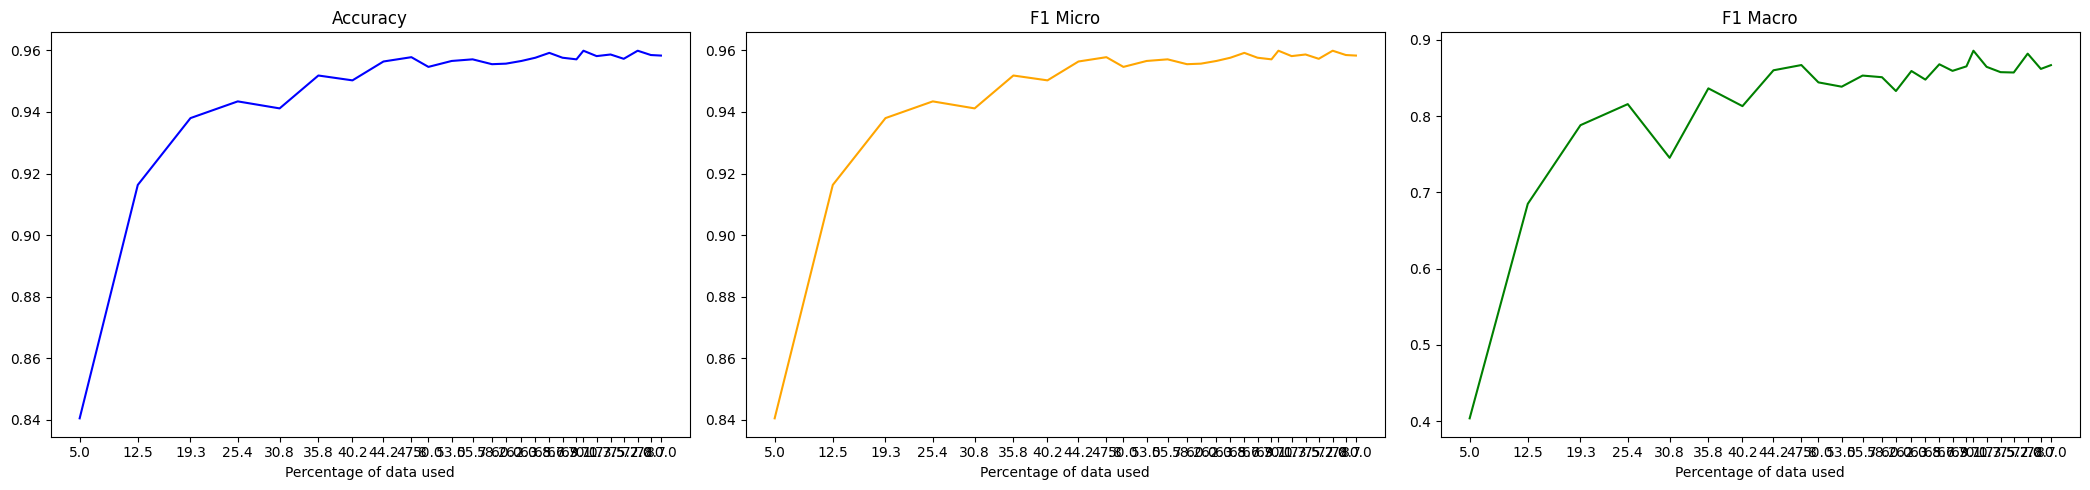

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6846, Accuracy: 0.7771, F1 Micro: 0.873, F1 Macro: 0.8661
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5356, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4856, Accuracy: 0.8019, F1 Micro: 0.8899, F1 Macro: 0.8853
Epoch 4/10, Train Loss: 0.4451, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 5/10, Train Loss: 0.447, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4104, Accuracy: 0.8038, F1 Micro: 0.8908, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4062, Accuracy: 0.8099, F1 Micro: 0.893, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4023, Accuracy: 0.8189, F1 Micro: 0.8974, F1 Macro: 0.8906
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3668, Accuracy: 0.8349, F1 Micro: 0.9047, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6158, Accuracy: 0.6141, F1 Micro: 0.6141, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4961, Accuracy: 0.6141, F1 Micro: 0.6141, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4198, Accuracy: 0.6141, F1 Micro: 0.6141, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4426, Accuracy: 0.6141, F1 Micro: 0.6141, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3147, Accuracy: 0.7391, F1 Micro: 0.7391, F1 Macro: 0.6783
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2361, Accuracy: 0.7636, F1 Micro: 0.7636, F1 Macro: 0.7349
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2395, Accuracy: 0.7663, F1 Micro: 0.7663, F1 Macro: 0.7452
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2328, Accuracy: 0.7935, F1 Micro: 0.7935, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.1405, Accuracy: 0.7799, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5863, Accuracy: 0.8024, F1 Micro: 0.89, F1 Macro: 0.8852
Epoch 2/10, Train Loss: 0.4496, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4409, Accuracy: 0.8095, F1 Micro: 0.8929, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4132, Accuracy: 0.8345, F1 Micro: 0.9055, F1 Macro: 0.8993
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3585, Accuracy: 0.8674, F1 Micro: 0.9227, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3142, Accuracy: 0.8884, F1 Micro: 0.9333, F1 Macro: 0.9267
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2689, Accuracy: 0.8965, F1 Micro: 0.938, F1 Macro: 0.9332
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.234, Accuracy: 0.9042, F1 Micro: 0.9426, F1 Macro: 0.9389
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2126, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.498, Accuracy: 0.7218, F1 Micro: 0.7218, F1 Macro: 0.4192
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3627, Accuracy: 0.8258, F1 Micro: 0.8258, F1 Macro: 0.7738
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2923, Accuracy: 0.839, F1 Micro: 0.839, F1 Macro: 0.7836
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2102, Accuracy: 0.8434, F1 Micro: 0.8434, F1 Macro: 0.7982
Epoch 5/10, Train Loss: 0.1889, Accuracy: 0.8412, F1 Micro: 0.8412, F1 Macro: 0.7948
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1253, Accuracy: 0.8554, F1 Micro: 0.8554, F1 Macro: 0.8082
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.8445, F1 Micro: 0.8445, F1 Macro: 0.8045
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.8631, F1 Micro: 0.8631, F1 Macro: 0.8143
Epoch 9/10, Train Loss: 0.0795, Accuracy: 0.8598, F1 Micro: 0.8598, F1 Macro: 0.8014
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.546, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4559, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.403, Accuracy: 0.8464, F1 Micro: 0.9116, F1 Macro: 0.9059
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3435, Accuracy: 0.8845, F1 Micro: 0.9311, F1 Macro: 0.924
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2852, Accuracy: 0.9057, F1 Micro: 0.9435, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2242, Accuracy: 0.9271, F1 Micro: 0.9559, F1 Macro: 0.9531
Epoch 7/10, Train Loss: 0.201, Accuracy: 0.9269, F1 Micro: 0.9557, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1791, Accuracy: 0.9351, F1 Micro: 0.9604, F1 Macro: 0.9579
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1512, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4783, Accuracy: 0.7527, F1 Micro: 0.7527, F1 Macro: 0.4294
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.297, Accuracy: 0.8266, F1 Micro: 0.8266, F1 Macro: 0.7697
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1749, Accuracy: 0.8694, F1 Micro: 0.8694, F1 Macro: 0.8107
Epoch 4/10, Train Loss: 0.1477, Accuracy: 0.8683, F1 Micro: 0.8683, F1 Macro: 0.8054
Epoch 5/10, Train Loss: 0.1337, Accuracy: 0.8619, F1 Micro: 0.8619, F1 Macro: 0.7766
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0759, Accuracy: 0.8897, F1 Micro: 0.8897, F1 Macro: 0.8365
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.8865, F1 Micro: 0.8865, F1 Macro: 0.8295
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.8737, F1 Micro: 0.8737, F1 Macro: 0.8051
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.8929, F1 Micro: 0.8929, F1 Macro: 0.8404
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0484, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5221, Accuracy: 0.8038, F1 Micro: 0.8908, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4434, Accuracy: 0.8205, F1 Micro: 0.8981, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3633, Accuracy: 0.884, F1 Micro: 0.9317, F1 Macro: 0.9269
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2841, Accuracy: 0.9064, F1 Micro: 0.944, F1 Macro: 0.9403
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2361, Accuracy: 0.9309, F1 Micro: 0.9579, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2006, Accuracy: 0.9366, F1 Micro: 0.9611, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1758, Accuracy: 0.9436, F1 Micro: 0.9654, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1526, Accuracy: 0.9441, F1 Micro: 0.9657, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4425, Accuracy: 0.8044, F1 Micro: 0.8044, F1 Macro: 0.7454
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2713, Accuracy: 0.8546, F1 Micro: 0.8546, F1 Macro: 0.8067
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.8616, F1 Micro: 0.8616, F1 Macro: 0.8096
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1479, Accuracy: 0.8786, F1 Micro: 0.8786, F1 Macro: 0.8244
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1316, Accuracy: 0.8806, F1 Micro: 0.8806, F1 Macro: 0.8306
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.084, Accuracy: 0.8837, F1 Micro: 0.8837, F1 Macro: 0.8346
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.056, Accuracy: 0.8897, F1 Micro: 0.8897, F1 Macro: 0.846
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.8907, F1 Micro: 0.8907, F1 Macro: 0.8476
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5195, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4162, Accuracy: 0.8446, F1 Micro: 0.911, F1 Macro: 0.9055
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3229, Accuracy: 0.899, F1 Micro: 0.9396, F1 Macro: 0.9351
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2476, Accuracy: 0.9253, F1 Micro: 0.9547, F1 Macro: 0.9516
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2001, Accuracy: 0.9366, F1 Micro: 0.9614, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1694, Accuracy: 0.9458, F1 Micro: 0.9668, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1484, Accuracy: 0.9484, F1 Micro: 0.9682, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1308, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4246, Accuracy: 0.8368, F1 Micro: 0.8368, F1 Macro: 0.7799
Epoch 2/10, Train Loss: 0.2162, Accuracy: 0.791, F1 Micro: 0.791, F1 Macro: 0.6097
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2106, Accuracy: 0.8706, F1 Micro: 0.8706, F1 Macro: 0.8044
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.8826, F1 Micro: 0.8826, F1 Macro: 0.8272
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.8965, F1 Micro: 0.8965, F1 Macro: 0.8577
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0723, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8598
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.8905, F1 Micro: 0.8905, F1 Macro: 0.8384
Epoch 8/10, Train Loss: 0.077, Accuracy: 0.8975, F1 Micro: 0.8975, F1 Macro: 0.8546
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.8995, F1 Micro: 0.8995, F1 Macro: 0.8608
Epoch 10/10, Train Loss: 0.0291, Accuracy: 0.8905, F1 Micro: 0.8905, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5089, Accuracy: 0.8043, F1 Micro: 0.8911, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4003, Accuracy: 0.8786, F1 Micro: 0.9286, F1 Macro: 0.9235
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.303, Accuracy: 0.9054, F1 Micro: 0.9435, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.235, Accuracy: 0.9323, F1 Micro: 0.959, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.191, Accuracy: 0.9425, F1 Micro: 0.965, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1646, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9663
Epoch 7/10, Train Loss: 0.1378, Accuracy: 0.9483, F1 Micro: 0.9682, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1178, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1003, Accuracy: 0.95

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4159, Accuracy: 0.8467, F1 Micro: 0.8467, F1 Macro: 0.8057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2349, Accuracy: 0.8659, F1 Micro: 0.8659, F1 Macro: 0.8189
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2092, Accuracy: 0.886, F1 Micro: 0.886, F1 Macro: 0.847
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1576, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.8683
Epoch 5/10, Train Loss: 0.107, Accuracy: 0.8956, F1 Micro: 0.8956, F1 Macro: 0.8695
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.8966, F1 Micro: 0.8966, F1 Macro: 0.8591
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.8994, F1 Micro: 0.8994, F1 Macro: 0.8657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.8736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8761
Epoch 10/10, Train Loss: 0.0358, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4981, Accuracy: 0.8016, F1 Micro: 0.8898, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3858, Accuracy: 0.8856, F1 Micro: 0.9325, F1 Macro: 0.9283
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2863, Accuracy: 0.9198, F1 Micro: 0.9512, F1 Macro: 0.9471
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2196, Accuracy: 0.9408, F1 Micro: 0.9638, F1 Macro: 0.9612
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.183, Accuracy: 0.9441, F1 Micro: 0.9658, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1507, Accuracy: 0.9481, F1 Micro: 0.9681, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1265, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1084, Accuracy: 0.958, F1 Micro: 0.9741, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4017, Accuracy: 0.8516, F1 Micro: 0.8516, F1 Macro: 0.7969
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2251, Accuracy: 0.8648, F1 Micro: 0.8648, F1 Macro: 0.8349
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1801, Accuracy: 0.8948, F1 Micro: 0.8948, F1 Macro: 0.8627
Epoch 4/10, Train Loss: 0.1235, Accuracy: 0.8873, F1 Micro: 0.8873, F1 Macro: 0.8546
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1012, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8799
Epoch 6/10, Train Loss: 0.0564, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8722
Epoch 7/10, Train Loss: 0.0573, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8764
Epoch 8/10, Train Loss: 0.0439, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8725
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8777
Epoch 10/10, Train Loss: 0.0385, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8685

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4958, Accuracy: 0.8095, F1 Micro: 0.8902, F1 Macro: 0.8728
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.37, Accuracy: 0.8979, F1 Micro: 0.9388, F1 Macro: 0.9334
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2621, Accuracy: 0.9309, F1 Micro: 0.9581, F1 Macro: 0.9556
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1952, Accuracy: 0.9444, F1 Micro: 0.9661, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1698, Accuracy: 0.9464, F1 Micro: 0.9671, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1363, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1188, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9718
Epoch 8/10, Train Loss: 0.0982, Accuracy: 0.9573, F1 Micro: 0.9737, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0883, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4035, Accuracy: 0.8203, F1 Micro: 0.8203, F1 Macro: 0.7309
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2287, Accuracy: 0.8743, F1 Micro: 0.8743, F1 Macro: 0.836
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1888, Accuracy: 0.8818, F1 Micro: 0.8818, F1 Macro: 0.8411
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1233, Accuracy: 0.8966, F1 Micro: 0.8966, F1 Macro: 0.867
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1073, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8742
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.8948, F1 Micro: 0.8948, F1 Macro: 0.8601
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.8966, F1 Micro: 0.8966, F1 Macro: 0.8625
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0453, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8765
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.879
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4921, Accuracy: 0.8073, F1 Micro: 0.8926, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3484, Accuracy: 0.8957, F1 Micro: 0.9382, F1 Macro: 0.9342
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.248, Accuracy: 0.9356, F1 Micro: 0.9608, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1951, Accuracy: 0.9458, F1 Micro: 0.9669, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1585, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9693
Epoch 6/10, Train Loss: 0.1327, Accuracy: 0.9509, F1 Micro: 0.9699, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.114, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0957, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0812, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3911, Accuracy: 0.8615, F1 Micro: 0.8615, F1 Macro: 0.8102
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.228, Accuracy: 0.8738, F1 Micro: 0.8738, F1 Macro: 0.8229
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1604, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8696
Epoch 4/10, Train Loss: 0.1179, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8625
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0954, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.888
Epoch 6/10, Train Loss: 0.0643, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8805
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8827
Epoch 8/10, Train Loss: 0.0377, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8798
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8737
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0267, Accuracy: 0.9165, F1 Micro: 0.9165, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4825, Accuracy: 0.803, F1 Micro: 0.8905, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3407, Accuracy: 0.9031, F1 Micro: 0.9422, F1 Macro: 0.9386
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2401, Accuracy: 0.9344, F1 Micro: 0.9601, F1 Macro: 0.9577
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1876, Accuracy: 0.9458, F1 Micro: 0.9669, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1535, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.9536, F1 Micro: 0.9714, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1101, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0968, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.399, Accuracy: 0.864, F1 Micro: 0.864, F1 Macro: 0.8242
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2081, Accuracy: 0.8912, F1 Micro: 0.8912, F1 Macro: 0.8608
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1601, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8783
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.115, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8883
Epoch 5/10, Train Loss: 0.0903, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8887
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.081, Accuracy: 0.9174, F1 Micro: 0.9174, F1 Macro: 0.8934
Epoch 7/10, Train Loss: 0.0418, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0486, Accuracy: 0.9193, F1 Micro: 0.9193, F1 Macro: 0.8954
Epoch 9/10, Train Loss: 0.0291, Accuracy: 0.9184, F1 Micro: 0.9184, F1 Macro: 0.8938
Epoch 10/10, Train Loss: 0.0258, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4854, Accuracy: 0.8109, F1 Micro: 0.8944, F1 Macro: 0.8898
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3373, Accuracy: 0.9038, F1 Micro: 0.9427, F1 Macro: 0.939
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2339, Accuracy: 0.942, F1 Micro: 0.9645, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1811, Accuracy: 0.95, F1 Micro: 0.9694, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1522, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1249, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1054, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4041, Accuracy: 0.8641, F1 Micro: 0.8641, F1 Macro: 0.8033
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2347, Accuracy: 0.889, F1 Micro: 0.889, F1 Macro: 0.8559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1547, Accuracy: 0.91, F1 Micro: 0.91, F1 Macro: 0.8815
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1309, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0748, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0578, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.8896
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0499, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.892
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0442, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.8936
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0404

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4808, Accuracy: 0.8339, F1 Micro: 0.9048, F1 Macro: 0.8977
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3234, Accuracy: 0.9149, F1 Micro: 0.9488, F1 Macro: 0.9455
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2286, Accuracy: 0.9389, F1 Micro: 0.9628, F1 Macro: 0.9606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1811, Accuracy: 0.9453, F1 Micro: 0.9665, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1508, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1221, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1075, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0747, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.364, Accuracy: 0.8659, F1 Micro: 0.8659, F1 Macro: 0.8269
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2177, Accuracy: 0.8939, F1 Micro: 0.8939, F1 Macro: 0.8597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1552, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.8692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0956, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8782
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0816, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8796
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0636, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8818
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0616, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8862
Epoch 8/10, Train Loss: 0.0359, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8757
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8846
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4786, Accuracy: 0.8297, F1 Micro: 0.9021, F1 Macro: 0.8946
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3263, Accuracy: 0.9149, F1 Micro: 0.9488, F1 Macro: 0.9459
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2173, Accuracy: 0.9446, F1 Micro: 0.966, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9509, F1 Micro: 0.9697, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.9549, F1 Micro: 0.9721, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.9557, F1 Micro: 0.9727, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0898, Accuracy: 0.9609, F1 Micro: 0.9759, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3531, Accuracy: 0.8706, F1 Micro: 0.8706, F1 Macro: 0.835
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.213, Accuracy: 0.8955, F1 Micro: 0.8955, F1 Macro: 0.8609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1495, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.864
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0978, Accuracy: 0.9214, F1 Micro: 0.9214, F1 Macro: 0.8958
Epoch 5/10, Train Loss: 0.071, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.8913
Epoch 6/10, Train Loss: 0.0545, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.8932
Epoch 7/10, Train Loss: 0.0503, Accuracy: 0.9204, F1 Micro: 0.9204, F1 Macro: 0.8949
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0317, Accuracy: 0.9233, F1 Micro: 0.9233, F1 Macro: 0.8991
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.9214, F1 Micro: 0.9214, F1 Macro: 0.898
Epoch 10/10, Train Loss: 0.0463, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4731, Accuracy: 0.8455, F1 Micro: 0.911, F1 Macro: 0.9053
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3101, Accuracy: 0.9191, F1 Micro: 0.9513, F1 Macro: 0.9482
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.217, Accuracy: 0.9427, F1 Micro: 0.9651, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1007, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9736
Epoch 8/10, Train Loss: 0.0827, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0685, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3624, Accuracy: 0.8663, F1 Micro: 0.8663, F1 Macro: 0.823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2108, Accuracy: 0.88, F1 Micro: 0.88, F1 Macro: 0.8467
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.143, Accuracy: 0.8956, F1 Micro: 0.8956, F1 Macro: 0.8621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0964, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0693, Accuracy: 0.9029, F1 Micro: 0.9029, F1 Macro: 0.8742
Epoch 6/10, Train Loss: 0.0499, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8702
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.058, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8782
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.036, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0192, Accuracy: 0.9057, F1 Micro: 0.90

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4714, Accuracy: 0.8552, F1 Micro: 0.915, F1 Macro: 0.9057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3078, Accuracy: 0.924, F1 Micro: 0.9539, F1 Macro: 0.9507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2111, Accuracy: 0.9465, F1 Micro: 0.9673, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9519, F1 Micro: 0.9705, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0947, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3537, Accuracy: 0.8671, F1 Micro: 0.8671, F1 Macro: 0.8124
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2156, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.867
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1258, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8758
Epoch 4/10, Train Loss: 0.1016, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.867
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.085, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0506, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8781
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.04, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8879
Epoch 8/10, Train Loss: 0.0335, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8827
Epoch 9/10, Train Loss: 0.0317, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8804
Epoch 10/10, Train Loss: 0.02, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4775, Accuracy: 0.8446, F1 Micro: 0.9111, F1 Macro: 0.9064
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3082, Accuracy: 0.9189, F1 Micro: 0.9513, F1 Macro: 0.9481
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2122, Accuracy: 0.9429, F1 Micro: 0.9651, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1668, Accuracy: 0.9528, F1 Micro: 0.9709, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1375, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9729
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.9587, F1 Micro: 0.9743, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0648, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3414, Accuracy: 0.8564, F1 Micro: 0.8564, F1 Macro: 0.8204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2073, Accuracy: 0.8932, F1 Micro: 0.8932, F1 Macro: 0.8571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1347, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8757
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0929, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8858
Epoch 5/10, Train Loss: 0.0702, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0612, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0475, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8864
Epoch 8/10, Train Loss: 0.0246, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.87
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8786
Epoch 10/10, Train Loss: 0.0312, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4659, Accuracy: 0.8642, F1 Micro: 0.9203, F1 Macro: 0.9136
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2928, Accuracy: 0.9281, F1 Micro: 0.9566, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.9455, F1 Micro: 0.9665, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1631, Accuracy: 0.9507, F1 Micro: 0.9698, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1314, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1077, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9735
Epoch 7/10, Train Loss: 0.0915, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0787, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.065, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3537, Accuracy: 0.8637, F1 Micro: 0.8637, F1 Macro: 0.8232
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.225, Accuracy: 0.8932, F1 Micro: 0.8932, F1 Macro: 0.8581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1427, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8871
Epoch 4/10, Train Loss: 0.1027, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8735
Epoch 5/10, Train Loss: 0.093, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8831
Epoch 6/10, Train Loss: 0.0618, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0419, Accuracy: 0.9162, F1 Micro: 0.9162, F1 Macro: 0.8899
Epoch 8/10, Train Loss: 0.0242, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.889
Epoch 9/10, Train Loss: 0.0309, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8872
Epoch 10/10, Train Loss: 0.0239, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8799

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4617, Accuracy: 0.8674, F1 Micro: 0.9223, F1 Macro: 0.9161
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2916, Accuracy: 0.9304, F1 Micro: 0.9577, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1963, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9505, F1 Micro: 0.9697, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.11, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0913, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0754, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0647, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3398, Accuracy: 0.865, F1 Micro: 0.865, F1 Macro: 0.8177
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.212, Accuracy: 0.8823, F1 Micro: 0.8823, F1 Macro: 0.8493
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1405, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.874
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1038, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8799
Epoch 5/10, Train Loss: 0.0673, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8705
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0522, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8814
Epoch 7/10, Train Loss: 0.0365, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8736
Epoch 8/10, Train Loss: 0.0319, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.8812
Epoch 9/10, Train Loss: 0.0291, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0243, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4686, Accuracy: 0.871, F1 Micro: 0.9248, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2858, Accuracy: 0.9335, F1 Micro: 0.9596, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1984, Accuracy: 0.9476, F1 Micro: 0.9679, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1604, Accuracy: 0.9517, F1 Micro: 0.9704, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1067, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9744
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0652, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3767, Accuracy: 0.8599, F1 Micro: 0.8599, F1 Macro: 0.8258
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2149, Accuracy: 0.8846, F1 Micro: 0.8846, F1 Macro: 0.8458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.15, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8888
Epoch 4/10, Train Loss: 0.1062, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.079, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.8985
Epoch 6/10, Train Loss: 0.0453, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8837
Epoch 7/10, Train Loss: 0.0358, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.8931
Epoch 8/10, Train Loss: 0.0278, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.8928
Epoch 9/10, Train Loss: 0.0214, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.8945
Epoch 10/10, Train Loss: 0.0184, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.893

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4675, Accuracy: 0.8799, F1 Micro: 0.9291, F1 Macro: 0.9237
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2777, Accuracy: 0.9358, F1 Micro: 0.9608, F1 Macro: 0.9577
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1542, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9564, F1 Micro: 0.9732, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1067, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.091, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9747
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.9608, F1 Micro: 0.9756, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0622, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3473, Accuracy: 0.8602, F1 Micro: 0.8602, F1 Macro: 0.8183
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1968, Accuracy: 0.8772, F1 Micro: 0.8772, F1 Macro: 0.8369
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1315, Accuracy: 0.8943, F1 Micro: 0.8943, F1 Macro: 0.8619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0915, Accuracy: 0.8952, F1 Micro: 0.8952, F1 Macro: 0.8633
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0856, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0679, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8792
Epoch 7/10, Train Loss: 0.0392, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8729
Epoch 8/10, Train Loss: 0.0354, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8698
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8687
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4595, Accuracy: 0.8767, F1 Micro: 0.9274, F1 Macro: 0.9216
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2837, Accuracy: 0.9373, F1 Micro: 0.9619, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2038, Accuracy: 0.9439, F1 Micro: 0.9658, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1586, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1068, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Epoch 7/10, Train Loss: 0.0878, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0752, Accuracy: 0.9658, F1 Micro: 0.9787, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3633, Accuracy: 0.8721, F1 Micro: 0.8721, F1 Macro: 0.8365
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1998, Accuracy: 0.8919, F1 Micro: 0.8919, F1 Macro: 0.859
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1394, Accuracy: 0.9018, F1 Micro: 0.9018, F1 Macro: 0.8777
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1019, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8779
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0751, Accuracy: 0.9054, F1 Micro: 0.9054, F1 Macro: 0.8779
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0508, Accuracy: 0.9054, F1 Micro: 0.9054, F1 Macro: 0.8745
Epoch 7/10, Train Loss: 0.0482, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0273, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8833
Epoch 9/10, Train Loss: 0.0254, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.878
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4578, Accuracy: 0.8764, F1 Micro: 0.927, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2758, Accuracy: 0.9387, F1 Micro: 0.9626, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.9483, F1 Micro: 0.9682, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.105, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0874, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0746, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 9/1

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3418, Accuracy: 0.873, F1 Micro: 0.873, F1 Macro: 0.8395
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1798, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1354, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.8944
Epoch 4/10, Train Loss: 0.0871, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8886
Epoch 5/10, Train Loss: 0.0684, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8819
Epoch 6/10, Train Loss: 0.0496, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8789
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0356, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.8978
Epoch 8/10, Train Loss: 0.0256, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.8933
Epoch 9/10, Train Loss: 0.0211, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.8962
Epoch 10/10, Train Loss: 0.0332, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.8902

Sentiment analysis accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4613, Accuracy: 0.8795, F1 Micro: 0.9283, F1 Macro: 0.9196
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2716, Accuracy: 0.9385, F1 Micro: 0.9626, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1901, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1551, Accuracy: 0.9517, F1 Micro: 0.9704, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9751
Epoch 6/10, Train Loss: 0.1027, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0853, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0606, Accuracy: 0.9658, F1 Micro: 0.9788, F1 Macro: 0.9764
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3637, Accuracy: 0.8801, F1 Micro: 0.8801, F1 Macro: 0.8435
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2013, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8724
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1281, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0956, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0582, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.8996
Epoch 6/10, Train Loss: 0.0469, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.8961
Epoch 7/10, Train Loss: 0.0417, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.8948
Epoch 8/10, Train Loss: 0.0238, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.8926
Epoch 9/10, Train Loss: 0.0253, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8895
Epoch 10/10, Train Loss: 0.0241, Accuracy: 0.9151, F1 Micro: 0.9151, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4457, Accuracy: 0.884, F1 Micro: 0.9313, F1 Macro: 0.9252
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.263, Accuracy: 0.9354, F1 Micro: 0.9607, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1887, Accuracy: 0.9512, F1 Micro: 0.9701, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1047, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.0857, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0709, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.9663, F1 Micro: 0.9791, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3307, Accuracy: 0.8588, F1 Micro: 0.8588, F1 Macro: 0.804
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1967, Accuracy: 0.8882, F1 Micro: 0.8882, F1 Macro: 0.8626
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1422, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8766
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0966, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0729, Accuracy: 0.9193, F1 Micro: 0.9193, F1 Macro: 0.8962
Epoch 6/10, Train Loss: 0.051, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.8931
Epoch 7/10, Train Loss: 0.0386, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.882
Epoch 8/10, Train Loss: 0.025, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8878
Epoch 9/10, Train Loss: 0.0285, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.889
Epoch 10/10, Train Loss: 0.0329, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4554, Accuracy: 0.8802, F1 Micro: 0.9294, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2653, Accuracy: 0.9335, F1 Micro: 0.9596, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.185, Accuracy: 0.949, F1 Micro: 0.9688, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1453, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.119, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9753
Epoch 7/10, Train Loss: 0.084, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3546, Accuracy: 0.8647, F1 Micro: 0.8647, F1 Macro: 0.8128
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1783, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.8816
Epoch 3/10, Train Loss: 0.1221, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0915, Accuracy: 0.9196, F1 Micro: 0.9196, F1 Macro: 0.8965
Epoch 5/10, Train Loss: 0.0607, Accuracy: 0.9095, F1 Micro: 0.9095, F1 Macro: 0.8796
Epoch 6/10, Train Loss: 0.0639, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8821
Epoch 7/10, Train Loss: 0.0507, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8851
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.915, F1 Micro: 0.915, F1 Macro: 0.8888
Epoch 9/10, Train Loss: 0.0261, Accuracy: 0.9159, F1 Micro: 0.9159, F1 Macro: 0.8891
Epoch 10/10, Train Loss: 0.0201, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8861

Sentiment analysis accuracy: 0.9196, F1 Micro: 0.91

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4405, Accuracy: 0.8889, F1 Micro: 0.9339, F1 Macro: 0.9281
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2621, Accuracy: 0.9354, F1 Micro: 0.9608, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1832, Accuracy: 0.9486, F1 Micro: 0.9684, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1432, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1008, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.9641, F1 Micro: 0.9776, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0558, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3568, Accuracy: 0.8615, F1 Micro: 0.8615, F1 Macro: 0.8188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2052, Accuracy: 0.8984, F1 Micro: 0.8984, F1 Macro: 0.873
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.129, Accuracy: 0.8984, F1 Micro: 0.8984, F1 Macro: 0.8698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.11, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0872, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8823
Epoch 6/10, Train Loss: 0.0609, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8682
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0564, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8823
Epoch 8/10, Train Loss: 0.0431, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8701
Epoch 9/10, Train Loss: 0.0296, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8774
Epoch 10/10, Train Loss: 0.0282, Accuracy

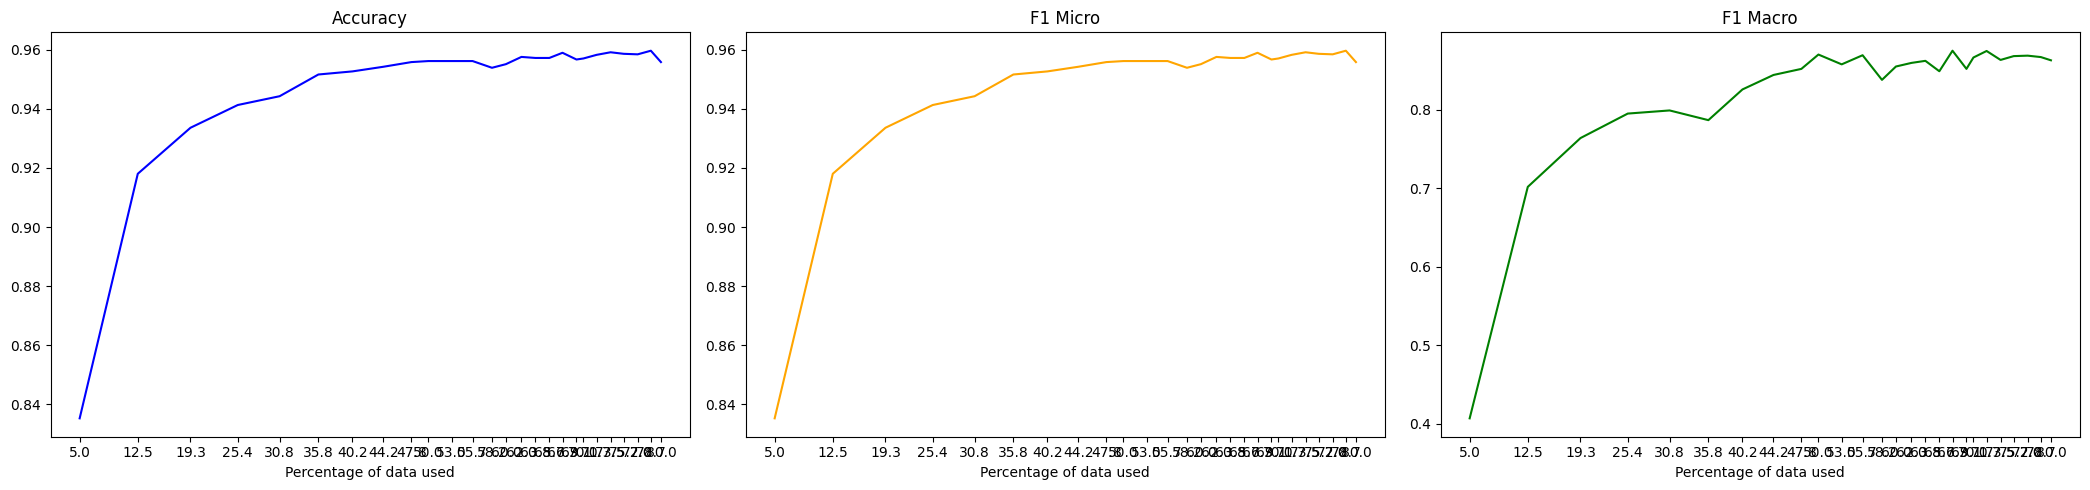

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6341, Accuracy: 0.7974, F1 Micro: 0.8859, F1 Macro: 0.8768
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5134, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4829, Accuracy: 0.8017, F1 Micro: 0.8897, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4632, Accuracy: 0.8045, F1 Micro: 0.8906, F1 Macro: 0.8847
Epoch 5/10, Train Loss: 0.4642, Accuracy: 0.8047, F1 Micro: 0.8903, F1 Macro: 0.8835
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4501, Accuracy: 0.8075, F1 Micro: 0.891, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.451, Accuracy: 0.8149, F1 Micro: 0.8947, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4034, Accuracy: 0.8273, F1 Micro: 0.9007, F1 Macro: 0.892
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3957, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7316, Accuracy: 0.5412, F1 Micro: 0.5412, F1 Macro: 0.3512
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.612, Accuracy: 0.5412, F1 Micro: 0.5412, F1 Macro: 0.3512
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5437, Accuracy: 0.5645, F1 Micro: 0.5645, F1 Macro: 0.4185
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5596, Accuracy: 0.5751, F1 Micro: 0.5751, F1 Macro: 0.4522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4998, Accuracy: 0.5877, F1 Micro: 0.5877, F1 Macro: 0.5659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.478, Accuracy: 0.6025, F1 Micro: 0.6025, F1 Macro: 0.5626
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3806, Accuracy: 0.666, F1 Micro: 0.666, F1 Macro: 0.6564
Epoch 8/10, Train Loss: 0.3522, Accuracy: 0.6195, F1 Micro: 0.6195, F1 Macro: 0.5823
Epoch 9/10, Train Loss: 0.3548, Accuracy: 0.6575, F1 Micro: 0.6575, F1 Macro: 0.6482
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5648, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4616, Accuracy: 0.8031, F1 Micro: 0.8901, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4413, Accuracy: 0.8095, F1 Micro: 0.8932, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4301, Accuracy: 0.8361, F1 Micro: 0.9052, F1 Macro: 0.8971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3745, Accuracy: 0.8616, F1 Micro: 0.9195, F1 Macro: 0.9149
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3251, Accuracy: 0.8828, F1 Micro: 0.9305, F1 Macro: 0.9252
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.293, Accuracy: 0.8939, F1 Micro: 0.937, F1 Macro: 0.9333
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2436, Accuracy: 0.9069, F1 Micro: 0.9443, F1 Macro: 0.9411
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5312, Accuracy: 0.7407, F1 Micro: 0.7407, F1 Macro: 0.4255
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4404, Accuracy: 0.7914, F1 Micro: 0.7914, F1 Macro: 0.7046
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3497, Accuracy: 0.8247, F1 Micro: 0.8247, F1 Macro: 0.7772
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2653, Accuracy: 0.8481, F1 Micro: 0.8481, F1 Macro: 0.7858
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2303, Accuracy: 0.8519, F1 Micro: 0.8519, F1 Macro: 0.793
Epoch 6/10, Train Loss: 0.1797, Accuracy: 0.8506, F1 Micro: 0.8506, F1 Macro: 0.7988
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1687, Accuracy: 0.8667, F1 Micro: 0.8667, F1 Macro: 0.8048
Epoch 8/10, Train Loss: 0.181, Accuracy: 0.8642, F1 Micro: 0.8642, F1 Macro: 0.8004
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1322, Accuracy: 0.879, F1 Micro: 0.879, F1 Macro: 0.8405
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5259, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4503, Accuracy: 0.8118, F1 Micro: 0.8947, F1 Macro: 0.8901
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4041, Accuracy: 0.847, F1 Micro: 0.9119, F1 Macro: 0.907
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3475, Accuracy: 0.8715, F1 Micro: 0.9249, F1 Macro: 0.9209
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2846, Accuracy: 0.8925, F1 Micro: 0.9364, F1 Macro: 0.9331
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2512, Accuracy: 0.9175, F1 Micro: 0.9503, F1 Macro: 0.947
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2087, Accuracy: 0.9264, F1 Micro: 0.9554, F1 Macro: 0.9523
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1833, Accuracy: 0.9326, F1 Micro: 0.9591, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4882, Accuracy: 0.7425, F1 Micro: 0.7425, F1 Macro: 0.5551
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3728, Accuracy: 0.8022, F1 Micro: 0.8022, F1 Macro: 0.699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.271, Accuracy: 0.8191, F1 Micro: 0.8191, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.209, Accuracy: 0.838, F1 Micro: 0.838, F1 Macro: 0.7939
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.182, Accuracy: 0.8509, F1 Micro: 0.8509, F1 Macro: 0.805
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1714, Accuracy: 0.8559, F1 Micro: 0.8559, F1 Macro: 0.8052
Epoch 7/10, Train Loss: 0.1284, Accuracy: 0.8439, F1 Micro: 0.8439, F1 Macro: 0.7849
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1109, Accuracy: 0.8579, F1 Micro: 0.8579, F1 Macro: 0.8074
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.8648, F1 Micro: 0.864

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5107, Accuracy: 0.8016, F1 Micro: 0.8898, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4425, Accuracy: 0.8165, F1 Micro: 0.897, F1 Macro: 0.8925
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3731, Accuracy: 0.8759, F1 Micro: 0.9266, F1 Macro: 0.9211
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3066, Accuracy: 0.9016, F1 Micro: 0.9413, F1 Macro: 0.9375
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2529, Accuracy: 0.9253, F1 Micro: 0.9548, F1 Macro: 0.9518
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2043, Accuracy: 0.9328, F1 Micro: 0.9591, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1737, Accuracy: 0.9387, F1 Micro: 0.9625, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1564, Accuracy: 0.9398, F1 Micro: 0.9632, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4915, Accuracy: 0.7915, F1 Micro: 0.7915, F1 Macro: 0.7091
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2874, Accuracy: 0.8537, F1 Micro: 0.8537, F1 Macro: 0.8068
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.8693, F1 Micro: 0.8693, F1 Macro: 0.8217
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.8807, F1 Micro: 0.8807, F1 Macro: 0.8453
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1536, Accuracy: 0.8952, F1 Micro: 0.8952, F1 Macro: 0.8627
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.868
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.8828, F1 Micro: 0.8828, F1 Macro: 0.8525
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0666, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8762
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9066, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4963, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4028, Accuracy: 0.8523, F1 Micro: 0.9143, F1 Macro: 0.9088
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3265, Accuracy: 0.8944, F1 Micro: 0.937, F1 Macro: 0.932
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2661, Accuracy: 0.9212, F1 Micro: 0.9525, F1 Macro: 0.949
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2177, Accuracy: 0.9292, F1 Micro: 0.9572, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1827, Accuracy: 0.9368, F1 Micro: 0.9616, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1481, Accuracy: 0.9439, F1 Micro: 0.9656, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1396, Accuracy: 0.9512, F1 Micro: 0.97, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4738, Accuracy: 0.8181, F1 Micro: 0.8181, F1 Macro: 0.7481
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3107, Accuracy: 0.8507, F1 Micro: 0.8507, F1 Macro: 0.8044
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2082, Accuracy: 0.8591, F1 Micro: 0.8591, F1 Macro: 0.8105
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1765, Accuracy: 0.8713, F1 Micro: 0.8713, F1 Macro: 0.83
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1474, Accuracy: 0.8722, F1 Micro: 0.8722, F1 Macro: 0.8365
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.8918, F1 Micro: 0.8918, F1 Macro: 0.8601
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.8834, F1 Micro: 0.8834, F1 Macro: 0.8443
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.8843, F1 Micro: 0.8843, F1 Macro: 0.8494
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.8871, F1 Micro: 0.8871, F1 Macro: 0.8536
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4965, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4059, Accuracy: 0.8632, F1 Micro: 0.9203, F1 Macro: 0.9147
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3127, Accuracy: 0.9059, F1 Micro: 0.9438, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2384, Accuracy: 0.9318, F1 Micro: 0.9586, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1957, Accuracy: 0.9382, F1 Micro: 0.9625, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1625, Accuracy: 0.9436, F1 Micro: 0.9656, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1429, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1229, Accuracy: 0.9516, F1 Micro: 0.9701, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.43, Accuracy: 0.8348, F1 Micro: 0.8348, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2513, Accuracy: 0.8443, F1 Micro: 0.8443, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1825, Accuracy: 0.8682, F1 Micro: 0.8682, F1 Macro: 0.8257
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.8787, F1 Micro: 0.8787, F1 Macro: 0.8361
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1299, Accuracy: 0.8863, F1 Micro: 0.8863, F1 Macro: 0.857
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0738, Accuracy: 0.8883, F1 Micro: 0.8883, F1 Macro: 0.8473
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9007, F1 Micro: 0.9007, F1 Macro: 0.8696
Epoch 8/10, Train Loss: 0.0428, Accuracy: 0.8949, F1 Micro: 0.8949, F1 Macro: 0.8617
Epoch 9/10, Train Loss: 0.0289, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.871
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4862, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3792, Accuracy: 0.8823, F1 Micro: 0.9302, F1 Macro: 0.9239
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2818, Accuracy: 0.9177, F1 Micro: 0.9505, F1 Macro: 0.9474
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2243, Accuracy: 0.9352, F1 Micro: 0.9607, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1794, Accuracy: 0.9457, F1 Micro: 0.9668, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.149, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1257, Accuracy: 0.9528, F1 Micro: 0.971, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1114, Accuracy: 0.9536, F1 Micro: 0.9714, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.424, Accuracy: 0.8496, F1 Micro: 0.8496, F1 Macro: 0.8027
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2507, Accuracy: 0.8582, F1 Micro: 0.8582, F1 Macro: 0.8259
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2025, Accuracy: 0.8822, F1 Micro: 0.8822, F1 Macro: 0.8473
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1425, Accuracy: 0.8946, F1 Micro: 0.8946, F1 Macro: 0.8619
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1099, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.8715
Epoch 6/10, Train Loss: 0.0624, Accuracy: 0.8994, F1 Micro: 0.8994, F1 Macro: 0.8709
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0592, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8834
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8723
Epoch 9/10, Train Loss: 0.0294, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8714
Epoch 10/10, Train Loss: 0.0217, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4863, Accuracy: 0.8035, F1 Micro: 0.8906, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3714, Accuracy: 0.8946, F1 Micro: 0.9374, F1 Macro: 0.9332
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2672, Accuracy: 0.9288, F1 Micro: 0.9569, F1 Macro: 0.9545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2062, Accuracy: 0.9405, F1 Micro: 0.9636, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1703, Accuracy: 0.9441, F1 Micro: 0.9659, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.146, Accuracy: 0.9528, F1 Micro: 0.9709, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1243, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9701
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.9538, F1 Micro: 0.9717, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0903, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4316, Accuracy: 0.8438, F1 Micro: 0.8438, F1 Macro: 0.7792
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2577, Accuracy: 0.8634, F1 Micro: 0.8634, F1 Macro: 0.8125
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.8868, F1 Micro: 0.8868, F1 Macro: 0.8524
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8727
Epoch 5/10, Train Loss: 0.1052, Accuracy: 0.8952, F1 Micro: 0.8952, F1 Macro: 0.8613
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0771, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8803
Epoch 7/10, Train Loss: 0.0366, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8724
Epoch 8/10, Train Loss: 0.0351, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8741
Epoch 9/10, Train Loss: 0.034, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.8613
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9036, F1 Micro: 0.9036, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4827, Accuracy: 0.8127, F1 Micro: 0.8942, F1 Macro: 0.8875
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.359, Accuracy: 0.8967, F1 Micro: 0.9387, F1 Macro: 0.9352
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2653, Accuracy: 0.9352, F1 Micro: 0.9606, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1964, Accuracy: 0.9392, F1 Micro: 0.963, F1 Macro: 0.9606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1678, Accuracy: 0.95, F1 Micro: 0.9691, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1422, Accuracy: 0.9569, F1 Micro: 0.9735, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1107, Accuracy: 0.9587, F1 Micro: 0.9746, F1 Macro: 0.9724
Epoch 8/10, Train Loss: 0.0983, Accuracy: 0.958, F1 Micro: 0.9741, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4335, Accuracy: 0.8364, F1 Micro: 0.8364, F1 Macro: 0.7696
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.8729, F1 Micro: 0.8729, F1 Macro: 0.8382
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1935, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1331, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8775
Epoch 5/10, Train Loss: 0.0856, Accuracy: 0.8985, F1 Micro: 0.8985, F1 Macro: 0.8685
Epoch 6/10, Train Loss: 0.0635, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.877
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0664, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.8832
Epoch 8/10, Train Loss: 0.0423, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8791
Epoch 9/10, Train Loss: 0.0334, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8827
Epoch 10/10, Train Loss: 0.0283, Accuracy: 0.9031, F1 Micro: 0.9031, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4743, Accuracy: 0.8222, F1 Micro: 0.8997, F1 Macro: 0.8951
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.344, Accuracy: 0.9052, F1 Micro: 0.9432, F1 Macro: 0.9396
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2517, Accuracy: 0.938, F1 Micro: 0.9622, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1954, Accuracy: 0.9443, F1 Micro: 0.9659, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1612, Accuracy: 0.9503, F1 Micro: 0.9696, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1314, Accuracy: 0.9547, F1 Micro: 0.972, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9724
Epoch 8/10, Train Loss: 0.0902, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9724
Epoch 9/10, Train Loss: 0.0799, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3923, Accuracy: 0.8531, F1 Micro: 0.8531, F1 Macro: 0.8162
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.242, Accuracy: 0.8719, F1 Micro: 0.8719, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1809, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1267, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0951, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.87
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0673, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8763
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.042, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.8956
Epoch 8/10, Train Loss: 0.0367, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8781
Epoch 9/10, Train Loss: 0.0186, Accuracy: 0.8964, F1 Micro: 0.8964, F1 Macro: 0.8607
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4682, Accuracy: 0.8326, F1 Micro: 0.9046, F1 Macro: 0.8996
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3426, Accuracy: 0.9111, F1 Micro: 0.9467, F1 Macro: 0.9436
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2284, Accuracy: 0.937, F1 Micro: 0.9617, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.9474, F1 Micro: 0.9678, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9745
Epoch 9/10, Train Loss: 0.076, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3886, Accuracy: 0.8481, F1 Micro: 0.8481, F1 Macro: 0.7841
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2307, Accuracy: 0.8751, F1 Micro: 0.8751, F1 Macro: 0.8346
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1652, Accuracy: 0.9021, F1 Micro: 0.9021, F1 Macro: 0.8747
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1206, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8859
Epoch 5/10, Train Loss: 0.0649, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8832
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0691, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8915
Epoch 7/10, Train Loss: 0.0515, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8806
Epoch 8/10, Train Loss: 0.0367, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8803
Epoch 9/10, Train Loss: 0.0188, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8773
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.9105, F1 Micro: 0.9105, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4594, Accuracy: 0.8377, F1 Micro: 0.9069, F1 Macro: 0.9014
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3397, Accuracy: 0.9142, F1 Micro: 0.9485, F1 Macro: 0.9454
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2314, Accuracy: 0.9389, F1 Micro: 0.9626, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9464, F1 Micro: 0.9673, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1482, Accuracy: 0.9533, F1 Micro: 0.9714, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1227, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9741
Epoch 7/10, Train Loss: 0.1046, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9731
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4134, Accuracy: 0.8607, F1 Micro: 0.8607, F1 Macro: 0.8112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2254, Accuracy: 0.8736, F1 Micro: 0.8736, F1 Macro: 0.8292
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1508, Accuracy: 0.8939, F1 Micro: 0.8939, F1 Macro: 0.8591
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1127, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.881
Epoch 5/10, Train Loss: 0.0751, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8841
Epoch 6/10, Train Loss: 0.0539, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8764
Epoch 7/10, Train Loss: 0.041, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8784
Epoch 8/10, Train Loss: 0.0394, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8753
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0247, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0234, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4698, Accuracy: 0.838, F1 Micro: 0.9073, F1 Macro: 0.9018
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.325, Accuracy: 0.9208, F1 Micro: 0.9521, F1 Macro: 0.9496
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2293, Accuracy: 0.9398, F1 Micro: 0.9632, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1788, Accuracy: 0.9465, F1 Micro: 0.9672, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1471, Accuracy: 0.9552, F1 Micro: 0.9725, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.118, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.9623, F1 Micro: 0.9765, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0902, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9743
Epoch 9/10, Train Loss: 0.0718, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3833, Accuracy: 0.8605, F1 Micro: 0.8605, F1 Macro: 0.8191
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.202, Accuracy: 0.8923, F1 Micro: 0.8923, F1 Macro: 0.8573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1342, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8825
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1062, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8802
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0707, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8908
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0579, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8903
Epoch 7/10, Train Loss: 0.0433, Accuracy: 0.9054, F1 Micro: 0.9054, F1 Macro: 0.8721
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0359, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.8917
Epoch 9/10, Train Loss: 0.0225, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8905
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.454, Accuracy: 0.85, F1 Micro: 0.9133, F1 Macro: 0.9077
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3096, Accuracy: 0.9238, F1 Micro: 0.9538, F1 Macro: 0.9509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2228, Accuracy: 0.9432, F1 Micro: 0.9653, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1714, Accuracy: 0.95, F1 Micro: 0.9692, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1403, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.112, Accuracy: 0.9569, F1 Micro: 0.9735, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0906, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.071, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3848, Accuracy: 0.8647, F1 Micro: 0.8647, F1 Macro: 0.8185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2257, Accuracy: 0.8876, F1 Micro: 0.8876, F1 Macro: 0.8529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1589, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1094, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.8892
Epoch 5/10, Train Loss: 0.0882, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.879
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0543, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.8882
Epoch 7/10, Train Loss: 0.0316, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8848
Epoch 8/10, Train Loss: 0.0447, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8866
Epoch 9/10, Train Loss: 0.032, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8859
Epoch 10/10, Train Loss: 0.026, Accuracy: 0.9068, F1 Micro: 0.9068, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4644, Accuracy: 0.845, F1 Micro: 0.9109, F1 Macro: 0.9056
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3116, Accuracy: 0.9212, F1 Micro: 0.9522, F1 Macro: 0.9483
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2155, Accuracy: 0.9422, F1 Micro: 0.9647, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.9507, F1 Micro: 0.9696, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1427, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0969, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9737
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.9648, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3521, Accuracy: 0.8467, F1 Micro: 0.8467, F1 Macro: 0.7842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2177, Accuracy: 0.8777, F1 Micro: 0.8777, F1 Macro: 0.8362
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1652, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1179, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.885
Epoch 5/10, Train Loss: 0.0936, Accuracy: 0.8914, F1 Micro: 0.8914, F1 Macro: 0.8554
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0564, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8817
Epoch 7/10, Train Loss: 0.0509, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8742
Epoch 8/10, Train Loss: 0.0331, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8686
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8867
Epoch 10/10, Train Loss: 0.0228, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4617, Accuracy: 0.85, F1 Micro: 0.9138, F1 Macro: 0.9091
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3007, Accuracy: 0.9233, F1 Micro: 0.9537, F1 Macro: 0.951
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2146, Accuracy: 0.9431, F1 Micro: 0.9652, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9464, F1 Micro: 0.9672, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9576, F1 Micro: 0.9737, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro: 0.9748
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.973
Epoch 8/10, Train Loss: 0.0809, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0691, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3703, Accuracy: 0.8491, F1 Micro: 0.8491, F1 Macro: 0.7786
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1994, Accuracy: 0.8838, F1 Micro: 0.8838, F1 Macro: 0.844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1419, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8819
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0973, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.8992
Epoch 5/10, Train Loss: 0.0911, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8892
Epoch 6/10, Train Loss: 0.0468, Accuracy: 0.9185, F1 Micro: 0.9185, F1 Macro: 0.8948
Epoch 7/10, Train Loss: 0.0524, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.8952
Epoch 8/10, Train Loss: 0.0321, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.8961
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0231, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.8981
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.028, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4571, Accuracy: 0.8627, F1 Micro: 0.9199, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2969, Accuracy: 0.9323, F1 Micro: 0.9589, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2029, Accuracy: 0.946, F1 Micro: 0.9669, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1588, Accuracy: 0.953, F1 Micro: 0.971, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1318, Accuracy: 0.9569, F1 Micro: 0.9735, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1063, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9731
Epoch 7/10, Train Loss: 0.0897, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.9658, F1 Micro: 0.9787, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9749
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3705, Accuracy: 0.8528, F1 Micro: 0.8528, F1 Macro: 0.8214
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2263, Accuracy: 0.8844, F1 Micro: 0.8844, F1 Macro: 0.847
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1546, Accuracy: 0.8925, F1 Micro: 0.8925, F1 Macro: 0.8593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1079, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0772, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8855
Epoch 6/10, Train Loss: 0.0521, Accuracy: 0.897, F1 Micro: 0.897, F1 Macro: 0.8641
Epoch 7/10, Train Loss: 0.0597, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8748
Epoch 8/10, Train Loss: 0.0341, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8717
Epoch 9/10, Train Loss: 0.0179, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8827
Epoch 10/10, Train Loss: 0.03, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4586, Accuracy: 0.8639, F1 Micro: 0.9208, F1 Macro: 0.9156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2864, Accuracy: 0.929, F1 Micro: 0.957, F1 Macro: 0.9543
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.9453, F1 Micro: 0.9666, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9528, F1 Micro: 0.971, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.107, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0896, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0782, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.0663, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.382, Accuracy: 0.8595, F1 Micro: 0.8595, F1 Macro: 0.8075
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2182, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8753
Epoch 3/10, Train Loss: 0.1407, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1077, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0649, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8905
Epoch 6/10, Train Loss: 0.0536, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.879
Epoch 7/10, Train Loss: 0.0403, Accuracy: 0.9155, F1 Micro: 0.9155, F1 Macro: 0.8894
Epoch 8/10, Train Loss: 0.0352, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8838
Epoch 9/10, Train Loss: 0.0348, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8877
Epoch 10/10, Train Loss: 0.0215, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8777

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4518, Accuracy: 0.8651, F1 Micro: 0.9209, F1 Macro: 0.9139
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2863, Accuracy: 0.9314, F1 Micro: 0.9583, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.9432, F1 Micro: 0.9654, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1544, Accuracy: 0.9543, F1 Micro: 0.9718, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9736
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9602, F1 Micro: 0.9755, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.0669, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9756
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3532, Accuracy: 0.86, F1 Micro: 0.86, F1 Macro: 0.82
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2225, Accuracy: 0.8867, F1 Micro: 0.8867, F1 Macro: 0.8447
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1499, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8777
Epoch 4/10, Train Loss: 0.0926, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8792
Epoch 5/10, Train Loss: 0.0918, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0458, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0513, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.8906
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0324, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.8947
Epoch 9/10, Train Loss: 0.0261, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8812
Epoch 10/10, Train Loss: 0.0282, Accuracy: 0.90

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4551, Accuracy: 0.8689, F1 Micro: 0.9231, F1 Macro: 0.9165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2845, Accuracy: 0.9316, F1 Micro: 0.9586, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1956, Accuracy: 0.949, F1 Micro: 0.9687, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1535, Accuracy: 0.9557, F1 Micro: 0.9727, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9757
Epoch 7/10, Train Loss: 0.0874, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9744
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.9637, F1 Micro: 0.9774, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9747
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3649, Accuracy: 0.8607, F1 Micro: 0.8607, F1 Macro: 0.813
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.239, Accuracy: 0.8964, F1 Micro: 0.8964, F1 Macro: 0.8705
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1637, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1109, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8823
Epoch 5/10, Train Loss: 0.0971, Accuracy: 0.8964, F1 Micro: 0.8964, F1 Macro: 0.8618
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0798, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8844
Epoch 7/10, Train Loss: 0.056, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.88
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8833
Epoch 9/10, Train Loss: 0.0303, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.865
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4457, Accuracy: 0.8644, F1 Micro: 0.9211, F1 Macro: 0.9163
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2761, Accuracy: 0.9276, F1 Micro: 0.9562, F1 Macro: 0.9539
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1976, Accuracy: 0.9451, F1 Micro: 0.9665, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1527, Accuracy: 0.9491, F1 Micro: 0.9689, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1243, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9755
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0749, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0613, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3633, Accuracy: 0.8654, F1 Micro: 0.8654, F1 Macro: 0.818
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2083, Accuracy: 0.8956, F1 Micro: 0.8956, F1 Macro: 0.8665
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1406, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8754
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0891, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0787, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0558, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0417, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.8915
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0392, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.8903
Epoch 9/10, Train Loss: 0.0276, Accuracy: 0.9121, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.447, Accuracy: 0.8741, F1 Micro: 0.926, F1 Macro: 0.9206
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2714, Accuracy: 0.9347, F1 Micro: 0.9603, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.949, F1 Micro: 0.9687, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.954, F1 Micro: 0.9718, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1017, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9758
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9746
Epoch 8/10, Train Loss: 0.0708, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9757
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3749, Accuracy: 0.8734, F1 Micro: 0.8734, F1 Macro: 0.8267
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2081, Accuracy: 0.9009, F1 Micro: 0.9009, F1 Macro: 0.8684
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.156, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8844
Epoch 4/10, Train Loss: 0.1241, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.878
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0912, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8833
Epoch 6/10, Train Loss: 0.0842, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8814
Epoch 7/10, Train Loss: 0.0561, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8788
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.886
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4434, Accuracy: 0.8734, F1 Micro: 0.9251, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2682, Accuracy: 0.9359, F1 Micro: 0.9609, F1 Macro: 0.9586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.187, Accuracy: 0.9523, F1 Micro: 0.9706, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1488, Accuracy: 0.9556, F1 Micro: 0.9725, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.124, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.087, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9753
Epoch 8/10, Train Loss: 0.0686, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3621, Accuracy: 0.8651, F1 Micro: 0.8651, F1 Macro: 0.829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2041, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.8721
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1461, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8767
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1042, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8839
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.082, Accuracy: 0.9165, F1 Micro: 0.9165, F1 Macro: 0.8923
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0777, Accuracy: 0.9174, F1 Micro: 0.9174, F1 Macro: 0.8929
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0623, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.8946
Epoch 8/10, Train Loss: 0.0325, Accuracy: 0.9165, F1 Micro: 0.9165, F1 Macro: 0.8939
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0294, Accuracy: 0.9183, F1 Micro: 0.9183

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4426, Accuracy: 0.8738, F1 Micro: 0.9257, F1 Macro: 0.9202
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2683, Accuracy: 0.9351, F1 Micro: 0.9604, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9477, F1 Micro: 0.968, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.0845, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0599, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3465, Accuracy: 0.8674, F1 Micro: 0.8674, F1 Macro: 0.8222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2034, Accuracy: 0.8892, F1 Micro: 0.8892, F1 Macro: 0.8518
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1424, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8819
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0875, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8889
Epoch 5/10, Train Loss: 0.0666, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8732
Epoch 6/10, Train Loss: 0.0626, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8821
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.055, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.8934
Epoch 8/10, Train Loss: 0.0404, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.883
Epoch 9/10, Train Loss: 0.027, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.883
Epoch 10/10, Train Loss: 0.0277, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4421, Accuracy: 0.8802, F1 Micro: 0.9285, F1 Macro: 0.9216
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2687, Accuracy: 0.9351, F1 Micro: 0.9605, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.188, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1456, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9757
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9742
Epoch 8/10, Train Loss: 0.0673, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9663, F1 Micro: 0.979, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3612, Accuracy: 0.8728, F1 Micro: 0.8728, F1 Macro: 0.8308
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2013, Accuracy: 0.901, F1 Micro: 0.901, F1 Macro: 0.8711
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.146, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8813
Epoch 4/10, Train Loss: 0.0956, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8773
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0739, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8918
Epoch 6/10, Train Loss: 0.0596, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.8907
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0306, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.8966
Epoch 8/10, Train Loss: 0.0343, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8861
Epoch 9/10, Train Loss: 0.0202, Accuracy: 0.9155, F1 Micro: 0.9155, F1 Macro: 0.8888
Epoch 10/10, Train Loss: 0.0382, Accuracy: 0.9164, F1 Micro: 0.9164, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4411, Accuracy: 0.8814, F1 Micro: 0.9299, F1 Macro: 0.9241
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.9349, F1 Micro: 0.9604, F1 Macro: 0.9579
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1876, Accuracy: 0.9502, F1 Micro: 0.9693, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.117, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9651, F1 Micro: 0.9784, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0665, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0586, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3606, Accuracy: 0.8662, F1 Micro: 0.8662, F1 Macro: 0.8151
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1984, Accuracy: 0.8899, F1 Micro: 0.8899, F1 Macro: 0.8494
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1319, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8759
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1018, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0705, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8889
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0565, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8884
Epoch 7/10, Train Loss: 0.0358, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8853
Epoch 8/10, Train Loss: 0.0315, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0286, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8871
Epoch

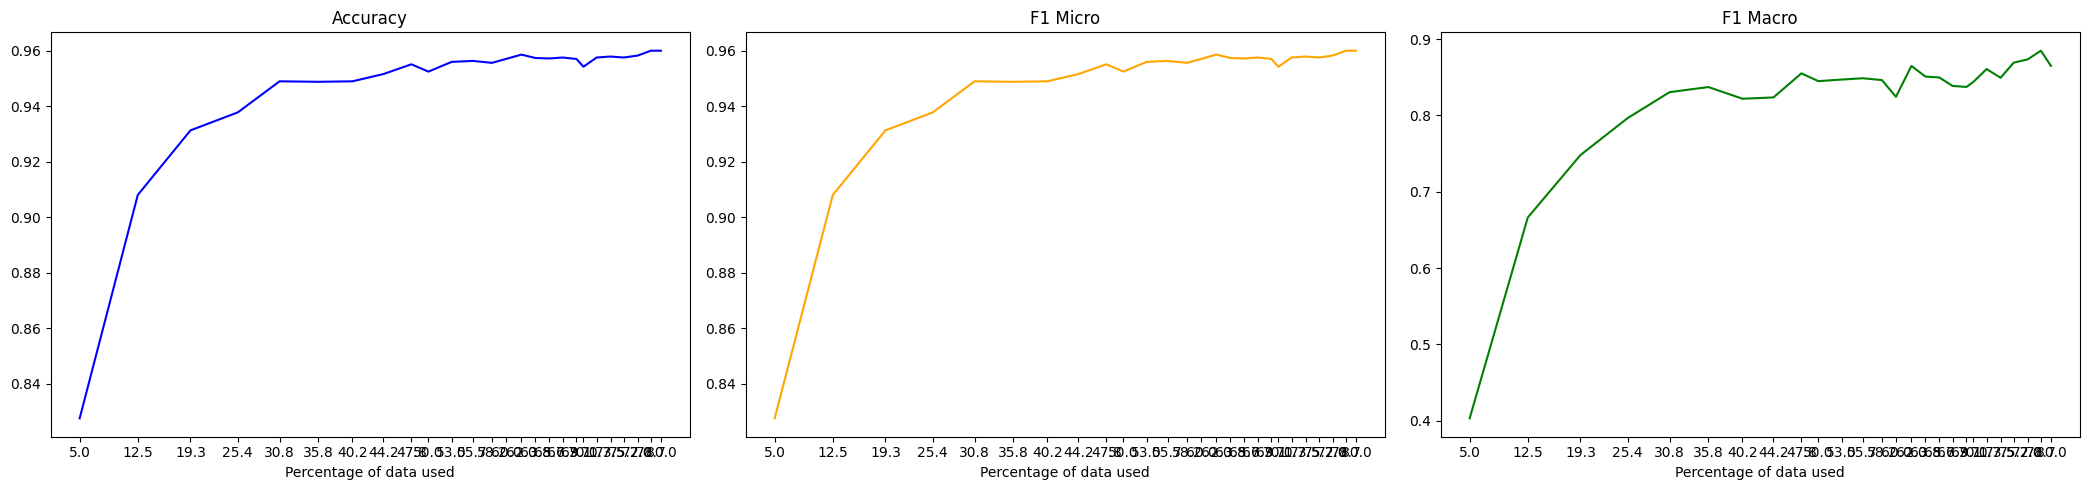

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6072, Accuracy: 0.7955, F1 Micro: 0.8818, F1 Macro: 0.8546
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4916, Accuracy: 0.8016, F1 Micro: 0.8877, F1 Macro: 0.8774
Epoch 3/10, Train Loss: 0.453, Accuracy: 0.8024, F1 Micro: 0.8857, F1 Macro: 0.8609
Epoch 4/10, Train Loss: 0.4515, Accuracy: 0.8021, F1 Micro: 0.8849, F1 Macro: 0.8543
Epoch 5/10, Train Loss: 0.417, Accuracy: 0.8047, F1 Micro: 0.8868, F1 Macro: 0.862
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4402, Accuracy: 0.8092, F1 Micro: 0.8902, F1 Macro: 0.874
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3799, Accuracy: 0.8141, F1 Micro: 0.8937, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3851, Accuracy: 0.8252, F1 Micro: 0.899, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3532, Accuracy: 0.8361, F1 Micro: 0.9044, F1 Macro: 0.8918
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5988, Accuracy: 0.6204, F1 Micro: 0.6204, F1 Macro: 0.3829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5281, Accuracy: 0.6204, F1 Micro: 0.6204, F1 Macro: 0.3829
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4888, Accuracy: 0.6259, F1 Micro: 0.6259, F1 Macro: 0.4027
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3707, Accuracy: 0.6861, F1 Micro: 0.6861, F1 Macro: 0.5752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3492, Accuracy: 0.7336, F1 Micro: 0.7336, F1 Macro: 0.6917
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2739, Accuracy: 0.7372, F1 Micro: 0.7372, F1 Macro: 0.7005
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3739, Accuracy: 0.7409, F1 Micro: 0.7409, F1 Macro: 0.7103
Epoch 8/10, Train Loss: 0.2974, Accuracy: 0.7281, F1 Micro: 0.7281, F1 Macro: 0.6718
Epoch 9/10, Train Loss: 0.18, Accuracy: 0.7372, F1 Micro: 0.7372, F1 Macro: 0.703
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5336, Accuracy: 0.8031, F1 Micro: 0.887, F1 Macro: 0.8693
Epoch 2/10, Train Loss: 0.4418, Accuracy: 0.8042, F1 Micro: 0.8868, F1 Macro: 0.8645
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4333, Accuracy: 0.8144, F1 Micro: 0.8946, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3941, Accuracy: 0.8392, F1 Micro: 0.9067, F1 Macro: 0.8973
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3346, Accuracy: 0.8745, F1 Micro: 0.925, F1 Macro: 0.9145
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2948, Accuracy: 0.8929, F1 Micro: 0.936, F1 Macro: 0.93
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2572, Accuracy: 0.9038, F1 Micro: 0.942, F1 Macro: 0.9368
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2127, Accuracy: 0.9122, F1 Micro: 0.9468, F1 Macro: 0.9422
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2048, Accuracy: 0.9155, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4981, Accuracy: 0.7315, F1 Micro: 0.7315, F1 Macro: 0.4225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3922, Accuracy: 0.7928, F1 Micro: 0.7928, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3477, Accuracy: 0.8032, F1 Micro: 0.8032, F1 Macro: 0.7005
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2849, Accuracy: 0.8322, F1 Micro: 0.8322, F1 Macro: 0.7559
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2419, Accuracy: 0.8322, F1 Micro: 0.8322, F1 Macro: 0.7386
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1514, Accuracy: 0.8519, F1 Micro: 0.8519, F1 Macro: 0.7953
Epoch 7/10, Train Loss: 0.1552, Accuracy: 0.8356, F1 Micro: 0.8356, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1421, Accuracy: 0.8576, F1 Micro: 0.8576, F1 Macro: 0.7982
Epoch 9/10, Train Loss: 0.0973, Accuracy: 0.8507, F1 Micro: 0.8507, F1 Macro: 0.7905
High

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5256, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.463, Accuracy: 0.8052, F1 Micro: 0.8913, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3997, Accuracy: 0.8627, F1 Micro: 0.9194, F1 Macro: 0.9112
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3306, Accuracy: 0.8917, F1 Micro: 0.9351, F1 Macro: 0.9287
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2719, Accuracy: 0.916, F1 Micro: 0.949, F1 Macro: 0.9439
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2405, Accuracy: 0.9273, F1 Micro: 0.9559, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1949, Accuracy: 0.9351, F1 Micro: 0.9605, F1 Macro: 0.9579
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1753, Accuracy: 0.9391, F1 Micro: 0.9626, F1 Macro: 0.9596
Epoch 9/10, Train Loss: 0.1496, Accuracy: 0.9372, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4845, Accuracy: 0.7651, F1 Micro: 0.7651, F1 Macro: 0.7226
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3744, Accuracy: 0.8315, F1 Micro: 0.8315, F1 Macro: 0.7804
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2393, Accuracy: 0.858, F1 Micro: 0.858, F1 Macro: 0.8022
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1896, Accuracy: 0.8744, F1 Micro: 0.8744, F1 Macro: 0.8281
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1742, Accuracy: 0.8836, F1 Micro: 0.8836, F1 Macro: 0.8422
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.8856, F1 Micro: 0.8856, F1 Macro: 0.8418
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.8795, F1 Micro: 0.8795, F1 Macro: 0.8367
Epoch 8/10, Train Loss: 0.0707, Accuracy: 0.8825, F1 Micro: 0.8825, F1 Macro: 0.8388
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0897, Accuracy: 0.8958, F1 Micro: 0.8958, F1 Macro: 0.85
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5, Accuracy: 0.8092, F1 Micro: 0.8931, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4267, Accuracy: 0.8373, F1 Micro: 0.907, F1 Macro: 0.9015
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3592, Accuracy: 0.8946, F1 Micro: 0.937, F1 Macro: 0.9311
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2799, Accuracy: 0.9062, F1 Micro: 0.944, F1 Macro: 0.9403
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2221, Accuracy: 0.9333, F1 Micro: 0.9595, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1878, Accuracy: 0.9349, F1 Micro: 0.9603, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1659, Accuracy: 0.9394, F1 Micro: 0.963, F1 Macro: 0.9607
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1491, Accuracy: 0.9432, F1 Micro: 0.9652, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1301

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4322, Accuracy: 0.7798, F1 Micro: 0.7798, F1 Macro: 0.6248
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.316, Accuracy: 0.8327, F1 Micro: 0.8327, F1 Macro: 0.7387
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.8796, F1 Micro: 0.8796, F1 Macro: 0.8298
Epoch 4/10, Train Loss: 0.1926, Accuracy: 0.8777, F1 Micro: 0.8777, F1 Macro: 0.826
Epoch 5/10, Train Loss: 0.1579, Accuracy: 0.8767, F1 Micro: 0.8767, F1 Macro: 0.8383
Epoch 6/10, Train Loss: 0.1299, Accuracy: 0.8728, F1 Micro: 0.8728, F1 Macro: 0.813
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1034, Accuracy: 0.8914, F1 Micro: 0.8914, F1 Macro: 0.8536
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0709, Accuracy: 0.8943, F1 Micro: 0.8943, F1 Macro: 0.8508
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.8904, F1 Micro: 0.8904, F1 Macro: 0.8457
Epoch 10/10, Train Loss: 0.0383, Accuracy: 0.8865, F1 Micro: 0.8865, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4914, Accuracy: 0.8089, F1 Micro: 0.8931, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.411, Accuracy: 0.8755, F1 Micro: 0.9266, F1 Macro: 0.9205
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3154, Accuracy: 0.905, F1 Micro: 0.9433, F1 Macro: 0.9391
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2403, Accuracy: 0.9314, F1 Micro: 0.9583, F1 Macro: 0.9556
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.197, Accuracy: 0.9401, F1 Micro: 0.9634, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1719, Accuracy: 0.9458, F1 Micro: 0.9667, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1523, Accuracy: 0.9493, F1 Micro: 0.9688, F1 Macro: 0.9669
Epoch 8/10, Train Loss: 0.1305, Accuracy: 0.949, F1 Micro: 0.9687, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1151, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4687, Accuracy: 0.8076, F1 Micro: 0.8076, F1 Macro: 0.731
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2952, Accuracy: 0.8416, F1 Micro: 0.8416, F1 Macro: 0.7931
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.8707, F1 Micro: 0.8707, F1 Macro: 0.8185
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.8727, F1 Micro: 0.8727, F1 Macro: 0.8238
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1239, Accuracy: 0.8921, F1 Micro: 0.8921, F1 Macro: 0.8536
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.102, Accuracy: 0.8941, F1 Micro: 0.8941, F1 Macro: 0.8517
Epoch 7/10, Train Loss: 0.0631, Accuracy: 0.8912, F1 Micro: 0.8912, F1 Macro: 0.8517
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.8776, F1 Micro: 0.8776, F1 Macro: 0.8225
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.8989, F1 Micro: 0.8989, F1 Macro: 0.8622
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4901, Accuracy: 0.8069, F1 Micro: 0.8922, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3831, Accuracy: 0.8825, F1 Micro: 0.9306, F1 Macro: 0.9252
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2876, Accuracy: 0.9194, F1 Micro: 0.9517, F1 Macro: 0.9485
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2222, Accuracy: 0.9368, F1 Micro: 0.9614, F1 Macro: 0.9586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1889, Accuracy: 0.946, F1 Micro: 0.9669, F1 Macro: 0.9647
Epoch 6/10, Train Loss: 0.1502, Accuracy: 0.9415, F1 Micro: 0.9643, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.138, Accuracy: 0.9476, F1 Micro: 0.9679, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1188, Accuracy: 0.9536, F1 Micro: 0.9714, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1014, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4473, Accuracy: 0.8287, F1 Micro: 0.8287, F1 Macro: 0.7453
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2609, Accuracy: 0.8402, F1 Micro: 0.8402, F1 Macro: 0.7525
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2262, Accuracy: 0.8756, F1 Micro: 0.8756, F1 Macro: 0.8247
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1785, Accuracy: 0.8804, F1 Micro: 0.8804, F1 Macro: 0.8277
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8808
Epoch 6/10, Train Loss: 0.0856, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8731
Epoch 7/10, Train Loss: 0.0635, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8644
Epoch 8/10, Train Loss: 0.0453, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8584
Epoch 9/10, Train Loss: 0.063, Accuracy: 0.8995, F1 Micro: 0.8995, F1 Macro: 0.861
Epoch 10/10, Train Loss: 0.0364, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.481, Accuracy: 0.8045, F1 Micro: 0.8912, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3584, Accuracy: 0.8981, F1 Micro: 0.9392, F1 Macro: 0.9343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2523, Accuracy: 0.9318, F1 Micro: 0.9584, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2008, Accuracy: 0.9424, F1 Micro: 0.9647, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1701, Accuracy: 0.9469, F1 Micro: 0.9674, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1438, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1231, Accuracy: 0.9516, F1 Micro: 0.9703, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1049, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4286, Accuracy: 0.8432, F1 Micro: 0.8432, F1 Macro: 0.7809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2554, Accuracy: 0.8706, F1 Micro: 0.8706, F1 Macro: 0.8287
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1842, Accuracy: 0.8924, F1 Micro: 0.8924, F1 Macro: 0.858
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1185, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.869
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0787, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8748
Epoch 6/10, Train Loss: 0.0708, Accuracy: 0.899, F1 Micro: 0.899, F1 Macro: 0.8627
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0605, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8806
Epoch 8/10, Train Loss: 0.0396, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8627
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.029, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8856
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.475, Accuracy: 0.8167, F1 Micro: 0.8965, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3501, Accuracy: 0.9052, F1 Micro: 0.9432, F1 Macro: 0.9386
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2503, Accuracy: 0.9368, F1 Micro: 0.9615, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1899, Accuracy: 0.9441, F1 Micro: 0.9658, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1664, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1375, Accuracy: 0.953, F1 Micro: 0.971, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1176, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1006, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.084,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3799, Accuracy: 0.8443, F1 Micro: 0.8443, F1 Macro: 0.8012
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2391, Accuracy: 0.8827, F1 Micro: 0.8827, F1 Macro: 0.8412
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1631, Accuracy: 0.9034, F1 Micro: 0.9034, F1 Macro: 0.8727
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1312, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8804
Epoch 5/10, Train Loss: 0.0962, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8776
Epoch 6/10, Train Loss: 0.0606, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.877
Epoch 7/10, Train Loss: 0.0506, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8764
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0335, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8817
Epoch 10/10, Train Loss: 0.0148, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4723, Accuracy: 0.8188, F1 Micro: 0.898, F1 Macro: 0.8934
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3376, Accuracy: 0.9139, F1 Micro: 0.9479, F1 Macro: 0.9433
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2427, Accuracy: 0.9398, F1 Micro: 0.9631, F1 Macro: 0.9606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.9465, F1 Micro: 0.9673, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1549, Accuracy: 0.949, F1 Micro: 0.9687, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.134, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1108, Accuracy: 0.954, F1 Micro: 0.9717, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.08

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.403, Accuracy: 0.7843, F1 Micro: 0.7843, F1 Macro: 0.6467
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2636, Accuracy: 0.8781, F1 Micro: 0.8781, F1 Macro: 0.8424
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1829, Accuracy: 0.8944, F1 Micro: 0.8944, F1 Macro: 0.8665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1335, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0855, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8715
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0679, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8772
Epoch 9/10, Train Loss: 0.0343, Accuracy: 0.8963, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4715, Accuracy: 0.8339, F1 Micro: 0.9055, F1 Macro: 0.9004
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.323, Accuracy: 0.9175, F1 Micro: 0.9502, F1 Macro: 0.9468
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2263, Accuracy: 0.9429, F1 Micro: 0.9651, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.183, Accuracy: 0.9444, F1 Micro: 0.9661, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1516, Accuracy: 0.95, F1 Micro: 0.9693, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1115, Accuracy: 0.958, F1 Micro: 0.9741, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0927, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0798, Accuracy: 0.9615, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3879, Accuracy: 0.8371, F1 Micro: 0.8371, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2294, Accuracy: 0.8655, F1 Micro: 0.8655, F1 Macro: 0.8128
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1697, Accuracy: 0.893, F1 Micro: 0.893, F1 Macro: 0.8604
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1173, Accuracy: 0.8966, F1 Micro: 0.8966, F1 Macro: 0.8655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1017, Accuracy: 0.9021, F1 Micro: 0.9021, F1 Macro: 0.874
Epoch 6/10, Train Loss: 0.0762, Accuracy: 0.8994, F1 Micro: 0.8994, F1 Macro: 0.8726
Epoch 7/10, Train Loss: 0.054, Accuracy: 0.8994, F1 Micro: 0.8994, F1 Macro: 0.8664
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.9003, F1 Micro: 0.9003, F1 Macro: 0.8687
Epoch 9/10, Train Loss: 0.0336, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.8697
Epoch 10/10, Train Loss: 0.0191, Accuracy: 0.892, F1 Micro: 0.892, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4635, Accuracy: 0.8401, F1 Micro: 0.9083, F1 Macro: 0.9026
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.31, Accuracy: 0.9214, F1 Micro: 0.9524, F1 Macro: 0.9487
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2187, Accuracy: 0.9443, F1 Micro: 0.9659, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9455, F1 Micro: 0.9667, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.971
Epoch 6/10, Train Loss: 0.1242, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0742, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.402, Accuracy: 0.8288, F1 Micro: 0.8288, F1 Macro: 0.7453
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2186, Accuracy: 0.8901, F1 Micro: 0.8901, F1 Macro: 0.8604
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1541, Accuracy: 0.8965, F1 Micro: 0.8965, F1 Macro: 0.8719
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1172, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8839
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0944, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8913
Epoch 6/10, Train Loss: 0.079, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8768
Epoch 7/10, Train Loss: 0.0616, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8898
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0474, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8887
Epoch 9/10, Train Loss: 0.0354, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8829
Epoch 10/10, Train Loss: 0.0262, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4667, Accuracy: 0.8523, F1 Micro: 0.9145, F1 Macro: 0.9086
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3106, Accuracy: 0.9273, F1 Micro: 0.9558, F1 Macro: 0.953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2189, Accuracy: 0.946, F1 Micro: 0.9668, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9491, F1 Micro: 0.9688, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9613, F1 Micro: 0.9761, F1 Macro: 0.9738
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.9571, F1 Micro: 0.9736, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0747, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3846, Accuracy: 0.8586, F1 Micro: 0.8586, F1 Macro: 0.8142
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2134, Accuracy: 0.8916, F1 Micro: 0.8916, F1 Macro: 0.8545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1293, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1089, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.876
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0869, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.054, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8907
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0316, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.8969
Epoch 8/10, Train Loss: 0.0293, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8863
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8862
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4631, Accuracy: 0.8677, F1 Micro: 0.9227, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2963, Accuracy: 0.9299, F1 Micro: 0.9573, F1 Macro: 0.9545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.9441, F1 Micro: 0.9658, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1674, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.9523, F1 Micro: 0.9707, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.9556, F1 Micro: 0.9727, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1003, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.975
Epoch 8/10, Train Loss: 0.0835, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9728
Epoch 9/10, Train Loss: 0.0696, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3772, Accuracy: 0.8558, F1 Micro: 0.8558, F1 Macro: 0.8012
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2186, Accuracy: 0.8878, F1 Micro: 0.8878, F1 Macro: 0.8466
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1446, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.8694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1156, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8843
Epoch 5/10, Train Loss: 0.0978, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8752
Epoch 6/10, Train Loss: 0.072, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8758
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0505, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8893
Epoch 8/10, Train Loss: 0.048, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Macro: 0.8855
Epoch 9/10, Train Loss: 0.0288, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8819
Epoch 10/10, Train Loss: 0.0218, Accuracy: 0.9142, F1 Micro: 0.9142, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4515, Accuracy: 0.862, F1 Micro: 0.9198, F1 Macro: 0.9143
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2921, Accuracy: 0.9332, F1 Micro: 0.9592, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2026, Accuracy: 0.9469, F1 Micro: 0.9674, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9477, F1 Micro: 0.9679, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1392, Accuracy: 0.9514, F1 Micro: 0.9702, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1162, Accuracy: 0.9568, F1 Micro: 0.9734, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0822, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.9625, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3615, Accuracy: 0.8554, F1 Micro: 0.8554, F1 Macro: 0.7997
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2216, Accuracy: 0.8897, F1 Micro: 0.8897, F1 Macro: 0.8567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1409, Accuracy: 0.8962, F1 Micro: 0.8962, F1 Macro: 0.862
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1113, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8685
Epoch 5/10, Train Loss: 0.0997, Accuracy: 0.8953, F1 Micro: 0.8953, F1 Macro: 0.857
Epoch 6/10, Train Loss: 0.0728, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8674
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0507, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8858
Epoch 8/10, Train Loss: 0.0332, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.873
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8703
Epoch 10/10, Train Loss: 0.0214, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4488, Accuracy: 0.8675, F1 Micro: 0.9219, F1 Macro: 0.9149
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2908, Accuracy: 0.9349, F1 Micro: 0.9603, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.9464, F1 Micro: 0.9671, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1367, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1126, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.0885, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9741
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.0665, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9744
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3769, Accuracy: 0.8595, F1 Micro: 0.8595, F1 Macro: 0.8057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2178, Accuracy: 0.8949, F1 Micro: 0.8949, F1 Macro: 0.8611
Epoch 3/10, Train Loss: 0.1364, Accuracy: 0.8912, F1 Micro: 0.8912, F1 Macro: 0.8529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1089, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0767, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0656, Accuracy: 0.9172, F1 Micro: 0.9172, F1 Macro: 0.8936
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0599, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.8952
Epoch 8/10, Train Loss: 0.0327, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8797
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0312, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.8962
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4556, Accuracy: 0.8752, F1 Micro: 0.9263, F1 Macro: 0.9202
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2808, Accuracy: 0.9352, F1 Micro: 0.9604, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.9699
Epoch 5/10, Train Loss: 0.1347, Accuracy: 0.9535, F1 Micro: 0.9715, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1068, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9738
Epoch 7/10, Train Loss: 0.0919, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.966, F1 Micro: 0.9788, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9753
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3741, Accuracy: 0.87, F1 Micro: 0.87, F1 Macro: 0.8331
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2153, Accuracy: 0.8873, F1 Micro: 0.8873, F1 Macro: 0.8548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1425, Accuracy: 0.8964, F1 Micro: 0.8964, F1 Macro: 0.8644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1038, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0763, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0534, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8819
Epoch 7/10, Train Loss: 0.0413, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8795
Epoch 8/10, Train Loss: 0.0381, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8777
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0288, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8894
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4484, Accuracy: 0.872, F1 Micro: 0.925, F1 Macro: 0.9194
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2723, Accuracy: 0.9326, F1 Micro: 0.959, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1934, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9672
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.9486, F1 Micro: 0.9686, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1056, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0914, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9753
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9733
Epoch 9/10, Train Loss: 0.0654, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9741
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3726, Accuracy: 0.8669, F1 Micro: 0.8669, F1 Macro: 0.8279
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.216, Accuracy: 0.8907, F1 Micro: 0.8907, F1 Macro: 0.86
Epoch 3/10, Train Loss: 0.1463, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8508
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1077, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0871, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8774
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8759
Epoch 7/10, Train Loss: 0.0627, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8754
Epoch 8/10, Train Loss: 0.0424, Accuracy: 0.9054, F1 Micro: 0.9054, F1 Macro: 0.8746
Epoch 9/10, Train Loss: 0.0348, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8696
Epoch 10/10, Train Loss: 0.0396, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8723

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4436, Accuracy: 0.8821, F1 Micro: 0.9302, F1 Macro: 0.9242
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2736, Accuracy: 0.9309, F1 Micro: 0.9582, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1896, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1575, Accuracy: 0.9538, F1 Micro: 0.9715, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.9575, F1 Micro: 0.9736, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0871, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0731, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.06, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3837, Accuracy: 0.855, F1 Micro: 0.855, F1 Macro: 0.7984
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.215, Accuracy: 0.8929, F1 Micro: 0.8929, F1 Macro: 0.8663
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1494, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Macro: 0.8852
Epoch 4/10, Train Loss: 0.1073, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0752, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0594, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8873
Epoch 7/10, Train Loss: 0.0482, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8836
Epoch 8/10, Train Loss: 0.0342, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Macro: 0.8865
Epoch 9/10, Train Loss: 0.0343, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0187, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4423, Accuracy: 0.8852, F1 Micro: 0.9318, F1 Macro: 0.9258
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2681, Accuracy: 0.9401, F1 Micro: 0.9633, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1909, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.9528, F1 Micro: 0.9709, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0878, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.966, F1 Micro: 0.9788, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.9646, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3664, Accuracy: 0.866, F1 Micro: 0.866, F1 Macro: 0.823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.213, Accuracy: 0.8874, F1 Micro: 0.8874, F1 Macro: 0.855
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.143, Accuracy: 0.8972, F1 Micro: 0.8972, F1 Macro: 0.8651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1136, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8793
Epoch 5/10, Train Loss: 0.0797, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8747
Epoch 6/10, Train Loss: 0.055, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8699
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0528, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8836
Epoch 8/10, Train Loss: 0.0394, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8775
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8803
Epoch 10/10, Train Loss: 0.0333, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4355, Accuracy: 0.8818, F1 Micro: 0.9302, F1 Macro: 0.9253
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2703, Accuracy: 0.9368, F1 Micro: 0.9615, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1903, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1503, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9729
Epoch 6/10, Train Loss: 0.0994, Accuracy: 0.9585, F1 Micro: 0.9745, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0706, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9758
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9611, F1 Micro: 0.9759, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.354, Accuracy: 0.8651, F1 Micro: 0.8651, F1 Macro: 0.8187
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1924, Accuracy: 0.8924, F1 Micro: 0.8924, F1 Macro: 0.8554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1297, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0982, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.8728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.085, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.064, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.886
Epoch 7/10, Train Loss: 0.0452, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8817
Epoch 8/10, Train Loss: 0.0353, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.882
Epoch 9/10, Train Loss: 0.0275, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8737
Epoch 10/10, Train Loss: 0.0205, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4386, Accuracy: 0.8835, F1 Micro: 0.9311, F1 Macro: 0.9258
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2619, Accuracy: 0.9373, F1 Micro: 0.9619, F1 Macro: 0.9597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1938, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9568, F1 Micro: 0.9734, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1067, Accuracy: 0.9635, F1 Micro: 0.9775, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0848, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0732, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.061, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3495, Accuracy: 0.8791, F1 Micro: 0.8791, F1 Macro: 0.8399
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2182, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8835
Epoch 3/10, Train Loss: 0.148, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8748
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1062, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.893
Epoch 5/10, Train Loss: 0.0715, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8885
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0735, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.8954
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.05, Accuracy: 0.926, F1 Micro: 0.926, F1 Macro: 0.902
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0415, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9054
Epoch 9/10, Train Loss: 0.0236, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.8966
Epoch 10/10, Train Loss: 0.0126, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4374, Accuracy: 0.8903, F1 Micro: 0.9347, F1 Macro: 0.929
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.257, Accuracy: 0.9394, F1 Micro: 0.9631, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1842, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9536, F1 Micro: 0.9716, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1028, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9753
Epoch 7/10, Train Loss: 0.082, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9749
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9735
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9739
Higher F1 achieved, saving m

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3728, Accuracy: 0.8586, F1 Micro: 0.8586, F1 Macro: 0.8001
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1898, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8702
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1227, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.866
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0982, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8846
Epoch 5/10, Train Loss: 0.0766, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8844
Epoch 6/10, Train Loss: 0.049, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0316, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8843
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0285, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.033, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.8865
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4348, Accuracy: 0.8889, F1 Micro: 0.9339, F1 Macro: 0.9285
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2512, Accuracy: 0.942, F1 Micro: 0.9645, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.12, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.0572, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3656, Accuracy: 0.8452, F1 Micro: 0.8452, F1 Macro: 0.7754
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2051, Accuracy: 0.8974, F1 Micro: 0.8974, F1 Macro: 0.8664
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1244, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8749
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0971, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.066, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0616, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0365, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0354, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8892
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.9093, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.433, Accuracy: 0.8913, F1 Micro: 0.9355, F1 Macro: 0.9308
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2479, Accuracy: 0.9439, F1 Micro: 0.9656, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1763, Accuracy: 0.9505, F1 Micro: 0.9697, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1432, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9758
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.9661, F1 Micro: 0.9789, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3424, Accuracy: 0.859, F1 Micro: 0.859, F1 Macro: 0.8193
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2103, Accuracy: 0.8969, F1 Micro: 0.8969, F1 Macro: 0.865
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1505, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8818
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1077, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Macro: 0.885
Epoch 5/10, Train Loss: 0.0792, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.8819
Epoch 6/10, Train Loss: 0.061, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0491, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.8964
Epoch 8/10, Train Loss: 0.0344, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.88
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.877
Epoch 10/10, Train Loss: 0.0198, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4326, Accuracy: 0.8958, F1 Micro: 0.9378, F1 Macro: 0.9331
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2443, Accuracy: 0.9451, F1 Micro: 0.9663, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1793, Accuracy: 0.9543, F1 Micro: 0.972, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1426, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1179, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0786, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0684, Accuracy: 0.9668, F1 Micro: 0.9794, F1 Macro: 0.9773
Epoch 9/10, Train Loss: 0.0567, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.345, Accuracy: 0.866, F1 Micro: 0.866, F1 Macro: 0.8253
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1778, Accuracy: 0.8903, F1 Micro: 0.8903, F1 Macro: 0.8641
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1212, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0893, Accuracy: 0.9047, F1 Micro: 0.9047, F1 Macro: 0.8764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0754, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.88
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0593, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8834
Epoch 7/10, Train Loss: 0.0439, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8728
Epoch 8/10, Train Loss: 0.0443, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8783
Epoch 9/10, Train Loss: 0.0235, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8789
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4332, Accuracy: 0.8899, F1 Micro: 0.9344, F1 Macro: 0.9286
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.244, Accuracy: 0.9432, F1 Micro: 0.9653, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1788, Accuracy: 0.9524, F1 Micro: 0.9708, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1399, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1155, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.975
Epoch 6/10, Train Loss: 0.0963, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0791, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3489, Accuracy: 0.8814, F1 Micro: 0.8814, F1 Macro: 0.8411
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1971, Accuracy: 0.9018, F1 Micro: 0.9018, F1 Macro: 0.8681
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.117, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0824, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.9044
Epoch 5/10, Train Loss: 0.0614, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8866
Epoch 6/10, Train Loss: 0.0456, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8845
Epoch 7/10, Train Loss: 0.0419, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9011
Epoch 8/10, Train Loss: 0.0262, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8867
Epoch 9/10, Train Loss: 0.0156, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.902
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0264, Accuracy: 0.9268, F1 Micro: 0.9268, F1 Macro:

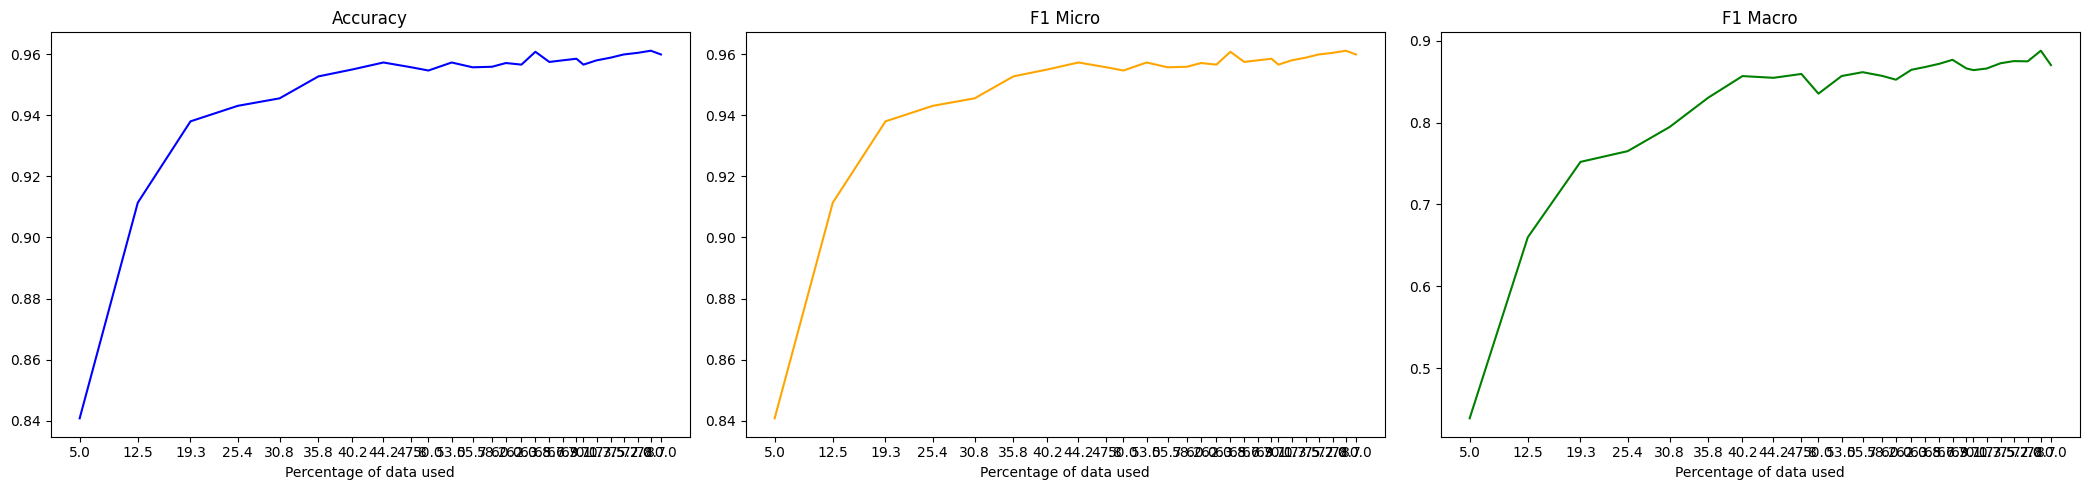

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6222, Accuracy: 0.7984, F1 Micro: 0.8875, F1 Macro: 0.8819
Epoch 2/10, Train Loss: 0.4944, Accuracy: 0.7981, F1 Micro: 0.8873, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4566, Accuracy: 0.7997, F1 Micro: 0.8881, F1 Macro: 0.8821
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4288, Accuracy: 0.8017, F1 Micro: 0.8893, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4243, Accuracy: 0.804, F1 Micro: 0.8907, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4161, Accuracy: 0.8135, F1 Micro: 0.8944, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4005, Accuracy: 0.8179, F1 Micro: 0.8965, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3794, Accuracy: 0.8247, F1 Micro: 0.9001, F1 Macro: 0.8939
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3213, Accuracy: 0.8417, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5506, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4796, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4879, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4287, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3515, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3849
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3279, Accuracy: 0.7, F1 Micro: 0.7, F1 Macro: 0.6242
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2793, Accuracy: 0.7073, F1 Micro: 0.7073, F1 Macro: 0.6432
Epoch 8/10, Train Loss: 0.202, Accuracy: 0.6873, F1 Micro: 0.6873, F1 Macro: 0.6008
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2003, Accuracy: 0.7309, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5589, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4694, Accuracy: 0.8045, F1 Micro: 0.8905, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4394, Accuracy: 0.8161, F1 Micro: 0.8955, F1 Macro: 0.8885
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3901, Accuracy: 0.8311, F1 Micro: 0.9038, F1 Macro: 0.8985
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3607, Accuracy: 0.8642, F1 Micro: 0.9203, F1 Macro: 0.9135
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3011, Accuracy: 0.8747, F1 Micro: 0.9262, F1 Macro: 0.9212
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2634, Accuracy: 0.8976, F1 Micro: 0.939, F1 Macro: 0.9353
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.236, Accuracy: 0.9095, F1 Micro: 0.9457, F1 Macro: 0.9425
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4826, Accuracy: 0.7101, F1 Micro: 0.7101, F1 Macro: 0.4153
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3642, Accuracy: 0.7559, F1 Micro: 0.7559, F1 Macro: 0.5885
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3311, Accuracy: 0.8027, F1 Micro: 0.8027, F1 Macro: 0.7424
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2169, Accuracy: 0.8082, F1 Micro: 0.8082, F1 Macro: 0.7243
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2333, Accuracy: 0.8227, F1 Micro: 0.8227, F1 Macro: 0.7419
Epoch 6/10, Train Loss: 0.166, Accuracy: 0.8149, F1 Micro: 0.8149, F1 Macro: 0.7229
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.178, Accuracy: 0.8239, F1 Micro: 0.8239, F1 Macro: 0.7544
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1521, Accuracy: 0.835, F1 Micro: 0.835, F1 Macro: 0.7636
Epoch 9/10, Train Loss: 0.1031, Accuracy: 0.825, F1 Micro: 0.825, F1 Macro: 0.7404
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5201, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4532, Accuracy: 0.8038, F1 Micro: 0.8908, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4001, Accuracy: 0.859, F1 Micro: 0.9176, F1 Macro: 0.9117
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3281, Accuracy: 0.8858, F1 Micro: 0.9323, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2667, Accuracy: 0.913, F1 Micro: 0.9477, F1 Macro: 0.9451
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2218, Accuracy: 0.9283, F1 Micro: 0.9563, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1856, Accuracy: 0.9323, F1 Micro: 0.9587, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1751, Accuracy: 0.9356, F1 Micro: 0.9608, F1 Macro: 0.9586
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4426, Accuracy: 0.7476, F1 Micro: 0.7476, F1 Macro: 0.5323
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.275, Accuracy: 0.8429, F1 Micro: 0.8429, F1 Macro: 0.7756
Epoch 3/10, Train Loss: 0.2305, Accuracy: 0.8419, F1 Micro: 0.8419, F1 Macro: 0.7738
Epoch 4/10, Train Loss: 0.1903, Accuracy: 0.8356, F1 Micro: 0.8356, F1 Macro: 0.7531
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1872, Accuracy: 0.8492, F1 Micro: 0.8492, F1 Macro: 0.8115
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1305, Accuracy: 0.8775, F1 Micro: 0.8775, F1 Macro: 0.8351
Epoch 7/10, Train Loss: 0.1425, Accuracy: 0.8723, F1 Micro: 0.8723, F1 Macro: 0.8258
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1039, Accuracy: 0.8817, F1 Micro: 0.8817, F1 Macro: 0.8334
Epoch 9/10, Train Loss: 0.0467, Accuracy: 0.8733, F1 Micro: 0.8733, F1 Macro: 0.8238
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0412, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4998, Accuracy: 0.8005, F1 Micro: 0.8892, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4137, Accuracy: 0.8253, F1 Micro: 0.9011, F1 Macro: 0.8958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3523, Accuracy: 0.879, F1 Micro: 0.9285, F1 Macro: 0.9244
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2825, Accuracy: 0.9116, F1 Micro: 0.9469, F1 Macro: 0.9439
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2291, Accuracy: 0.9337, F1 Micro: 0.9597, F1 Macro: 0.9572
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1891, Accuracy: 0.9372, F1 Micro: 0.9616, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1654, Accuracy: 0.9422, F1 Micro: 0.9646, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1415, Accuracy: 0.9425, F1 Micro: 0.9649, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4545, Accuracy: 0.7342, F1 Micro: 0.7342, F1 Macro: 0.5178
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2968, Accuracy: 0.8467, F1 Micro: 0.8467, F1 Macro: 0.7854
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2179, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.8046
Epoch 4/10, Train Loss: 0.1957, Accuracy: 0.8543, F1 Micro: 0.8543, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1505, Accuracy: 0.8761, F1 Micro: 0.8761, F1 Macro: 0.8344
Epoch 6/10, Train Loss: 0.1159, Accuracy: 0.8694, F1 Micro: 0.8694, F1 Macro: 0.8258
Epoch 7/10, Train Loss: 0.0961, Accuracy: 0.8732, F1 Micro: 0.8732, F1 Macro: 0.8282
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.8912, F1 Micro: 0.8912, F1 Macro: 0.8572
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.8893, F1 Micro: 0.8893, F1 Macro: 0.8518
Epoch 10/10, Train Loss: 0.0771, Accuracy: 0.8865, F1 Micro: 0.8865, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4987, Accuracy: 0.8036, F1 Micro: 0.8861, F1 Macro: 0.8597
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4169, Accuracy: 0.8472, F1 Micro: 0.9124, F1 Macro: 0.9078
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3282, Accuracy: 0.9082, F1 Micro: 0.9449, F1 Macro: 0.9409
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2565, Accuracy: 0.9311, F1 Micro: 0.9579, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1977, Accuracy: 0.9382, F1 Micro: 0.9625, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1733, Accuracy: 0.9465, F1 Micro: 0.9672, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1471, Accuracy: 0.9495, F1 Micro: 0.9689, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1265, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4437, Accuracy: 0.843, F1 Micro: 0.843, F1 Macro: 0.8028
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2675, Accuracy: 0.8553, F1 Micro: 0.8553, F1 Macro: 0.7993
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.8609, F1 Micro: 0.8609, F1 Macro: 0.8137
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1345, Accuracy: 0.8903, F1 Micro: 0.8903, F1 Macro: 0.8578
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.8846, F1 Micro: 0.8846, F1 Macro: 0.8511
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0975, Accuracy: 0.8903, F1 Micro: 0.8903, F1 Macro: 0.8561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.8921, F1 Micro: 0.8921, F1 Macro: 0.8634
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0369, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8701
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.8903, F1 Micro: 0.8903, F1 Macro: 0.8547
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.492, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3985, Accuracy: 0.8646, F1 Micro: 0.9204, F1 Macro: 0.9137
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2988, Accuracy: 0.9128, F1 Micro: 0.9476, F1 Macro: 0.9436
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2258, Accuracy: 0.9359, F1 Micro: 0.9609, F1 Macro: 0.9577
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1813, Accuracy: 0.9443, F1 Micro: 0.9659, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1536, Accuracy: 0.9476, F1 Micro: 0.9678, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1328, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1099, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9712
Epoch 9/10, Train Loss: 0.1006, Accuracy: 0.9556, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3956, Accuracy: 0.8456, F1 Micro: 0.8456, F1 Macro: 0.795
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2433, Accuracy: 0.8636, F1 Micro: 0.8636, F1 Macro: 0.8238
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2081, Accuracy: 0.8722, F1 Micro: 0.8722, F1 Macro: 0.8298
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1306, Accuracy: 0.8873, F1 Micro: 0.8873, F1 Macro: 0.8525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1029, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0764, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8704
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8667
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8705
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4883, Accuracy: 0.8012, F1 Micro: 0.8895, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3771, Accuracy: 0.8877, F1 Micro: 0.9333, F1 Macro: 0.9282
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2729, Accuracy: 0.9302, F1 Micro: 0.9576, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2102, Accuracy: 0.9361, F1 Micro: 0.961, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1675, Accuracy: 0.9458, F1 Micro: 0.9668, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.9689
Epoch 7/10, Train Loss: 0.1228, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.105, Accuracy: 0.9564, F1 Micro: 0.9732, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0908, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4275, Accuracy: 0.8453, F1 Micro: 0.8453, F1 Macro: 0.7964
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2243, Accuracy: 0.8625, F1 Micro: 0.8625, F1 Macro: 0.8144
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.179, Accuracy: 0.8797, F1 Micro: 0.8797, F1 Macro: 0.8384
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1337, Accuracy: 0.894, F1 Micro: 0.894, F1 Macro: 0.8586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0971, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0543, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8847
Epoch 7/10, Train Loss: 0.0422, Accuracy: 0.8949, F1 Micro: 0.8949, F1 Macro: 0.8621
Epoch 8/10, Train Loss: 0.0328, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8724
Epoch 9/10, Train Loss: 0.0291, Accuracy: 0.9007, F1 Micro: 0.9007, F1 Macro: 0.8706
Epoch 10/10, Train Loss: 0.0406, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4683, Accuracy: 0.8071, F1 Micro: 0.8921, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3638, Accuracy: 0.8986, F1 Micro: 0.9397, F1 Macro: 0.9351
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2508, Accuracy: 0.9299, F1 Micro: 0.9575, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1947, Accuracy: 0.9429, F1 Micro: 0.965, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1602, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1322, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.114, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0985, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4121, Accuracy: 0.8501, F1 Micro: 0.8501, F1 Macro: 0.8082
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2268, Accuracy: 0.8794, F1 Micro: 0.8794, F1 Macro: 0.8402
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1663, Accuracy: 0.8907, F1 Micro: 0.8907, F1 Macro: 0.8519
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1247, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0813, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.8736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0779, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Macro: 0.8865
Epoch 7/10, Train Loss: 0.0481, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.883
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.8827
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9095, F1 Micro: 0.9095, F1 Macro: 0.8816
Epoch 10/10, Train Loss: 0.0614, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4745, Accuracy: 0.8158, F1 Micro: 0.8967, F1 Macro: 0.8922
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3505, Accuracy: 0.9083, F1 Micro: 0.9453, F1 Macro: 0.9423
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2428, Accuracy: 0.9377, F1 Micro: 0.9621, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1838, Accuracy: 0.9476, F1 Micro: 0.9678, F1 Macro: 0.9655
Epoch 5/10, Train Loss: 0.1507, Accuracy: 0.9467, F1 Micro: 0.9674, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.131, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1093, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.973
Epoch 8/10, Train Loss: 0.0924, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9723
Epoch 9/10, Train Loss: 0.0782, Accuracy: 0.9597, F1 Micro: 0.975, F1 Macro: 0.9726
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4109, Accuracy: 0.823, F1 Micro: 0.823, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2321, Accuracy: 0.8745, F1 Micro: 0.8745, F1 Macro: 0.8335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1767, Accuracy: 0.8886, F1 Micro: 0.8886, F1 Macro: 0.8555
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1039, Accuracy: 0.8923, F1 Micro: 0.8923, F1 Macro: 0.8573
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0791, Accuracy: 0.8998, F1 Micro: 0.8998, F1 Macro: 0.8676
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0693, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8814
Epoch 7/10, Train Loss: 0.0489, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8779
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0345, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.9092, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4668, Accuracy: 0.817, F1 Micro: 0.8974, F1 Macro: 0.8928
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3401, Accuracy: 0.9144, F1 Micro: 0.9487, F1 Macro: 0.945
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.23, Accuracy: 0.9385, F1 Micro: 0.9625, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1798, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1443, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1256, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1038, Accuracy: 0.9604, F1 Micro: 0.9754, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0909, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3966, Accuracy: 0.8546, F1 Micro: 0.8546, F1 Macro: 0.7967
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.248, Accuracy: 0.8678, F1 Micro: 0.8678, F1 Macro: 0.8125
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1652, Accuracy: 0.8867, F1 Micro: 0.8867, F1 Macro: 0.8467
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1287, Accuracy: 0.8952, F1 Micro: 0.8952, F1 Macro: 0.866
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0714, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8818
Epoch 6/10, Train Loss: 0.0667, Accuracy: 0.899, F1 Micro: 0.899, F1 Macro: 0.8624
Epoch 7/10, Train Loss: 0.0678, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8724
Epoch 8/10, Train Loss: 0.0452, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0359, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8797
Epoch 10/10, Train Loss: 0.0226, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4664, Accuracy: 0.8285, F1 Micro: 0.9019, F1 Macro: 0.8947
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3285, Accuracy: 0.9217, F1 Micro: 0.9526, F1 Macro: 0.9493
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2241, Accuracy: 0.9429, F1 Micro: 0.9651, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1765, Accuracy: 0.9474, F1 Micro: 0.9677, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9573, F1 Micro: 0.9735, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9755
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3805, Accuracy: 0.859, F1 Micro: 0.859, F1 Macro: 0.8084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2081, Accuracy: 0.8729, F1 Micro: 0.8729, F1 Macro: 0.831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.163, Accuracy: 0.8776, F1 Micro: 0.8776, F1 Macro: 0.8291
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1064, Accuracy: 0.8952, F1 Micro: 0.8952, F1 Macro: 0.8602
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0785, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8864
Epoch 6/10, Train Loss: 0.0546, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8757
Epoch 7/10, Train Loss: 0.0482, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.878
Epoch 8/10, Train Loss: 0.0438, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8799
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8802
Epoch 10/10, Train Loss: 0.0432, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4645, Accuracy: 0.8344, F1 Micro: 0.9057, F1 Macro: 0.9006
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3247, Accuracy: 0.9264, F1 Micro: 0.9554, F1 Macro: 0.9526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2181, Accuracy: 0.9427, F1 Micro: 0.965, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9509, F1 Micro: 0.9698, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1414, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9604, F1 Micro: 0.9754, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3594, Accuracy: 0.8609, F1 Micro: 0.8609, F1 Macro: 0.8009
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2264, Accuracy: 0.8816, F1 Micro: 0.8816, F1 Macro: 0.8437
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1426, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.8662
Epoch 4/10, Train Loss: 0.1132, Accuracy: 0.8957, F1 Micro: 0.8957, F1 Macro: 0.8666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0861, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8793
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.053, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0466, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0303, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8861
Epoch 9/10, Train Loss: 0.0359, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8797
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4625, Accuracy: 0.8411, F1 Micro: 0.9091, F1 Macro: 0.9044
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3111, Accuracy: 0.9314, F1 Micro: 0.9581, F1 Macro: 0.955
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2125, Accuracy: 0.9396, F1 Micro: 0.9632, F1 Macro: 0.9606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1674, Accuracy: 0.9503, F1 Micro: 0.9696, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9563, F1 Micro: 0.9729, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1145, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0959, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0802, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9755
Epoch 9/10, Train Loss: 0.0704, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3598, Accuracy: 0.8675, F1 Micro: 0.8675, F1 Macro: 0.8205
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2255, Accuracy: 0.8906, F1 Micro: 0.8906, F1 Macro: 0.8557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1591, Accuracy: 0.899, F1 Micro: 0.899, F1 Macro: 0.8662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1071, Accuracy: 0.9018, F1 Micro: 0.9018, F1 Macro: 0.8688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0884, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8764
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0668, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.065, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8869
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0289, Accuracy: 0.9147, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.464, Accuracy: 0.8418, F1 Micro: 0.9097, F1 Macro: 0.905
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2979, Accuracy: 0.9283, F1 Micro: 0.9566, F1 Macro: 0.9541
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.958, F1 Micro: 0.9741, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0925, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3508, Accuracy: 0.87, F1 Micro: 0.87, F1 Macro: 0.8244
Epoch 2/10, Train Loss: 0.2093, Accuracy: 0.8691, F1 Micro: 0.8691, F1 Macro: 0.8146
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1512, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8763
Epoch 4/10, Train Loss: 0.1001, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8658
Epoch 5/10, Train Loss: 0.0969, Accuracy: 0.8904, F1 Micro: 0.8904, F1 Macro: 0.8504
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0524, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8839
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0618, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8812
Epoch 8/10, Train Loss: 0.0358, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8759
Epoch 9/10, Train Loss: 0.0467, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.876
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8627

Sentiment analysis accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4641, Accuracy: 0.8514, F1 Micro: 0.9143, F1 Macro: 0.9097
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2964, Accuracy: 0.9306, F1 Micro: 0.9579, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2044, Accuracy: 0.9438, F1 Micro: 0.9656, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1104, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9745
Epoch 8/10, Train Loss: 0.0775, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9736
Epoch 9/10, Train Loss: 0.0659, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9746
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3421, Accuracy: 0.8539, F1 Micro: 0.8539, F1 Macro: 0.7972
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1973, Accuracy: 0.864, F1 Micro: 0.864, F1 Macro: 0.8105
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1342, Accuracy: 0.8934, F1 Micro: 0.8934, F1 Macro: 0.8589
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1092, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.8724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0833, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8648
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0589, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8793
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0589, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8787
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.044, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8835
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.02

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4587, Accuracy: 0.8594, F1 Micro: 0.9182, F1 Macro: 0.9131
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2923, Accuracy: 0.9304, F1 Micro: 0.9577, F1 Macro: 0.955
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1953, Accuracy: 0.9467, F1 Micro: 0.9674, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1588, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1274, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9737
Epoch 6/10, Train Loss: 0.1075, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.9649, F1 Micro: 0.9783, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0672, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3453, Accuracy: 0.8594, F1 Micro: 0.8594, F1 Macro: 0.8024
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2012, Accuracy: 0.8883, F1 Micro: 0.8883, F1 Macro: 0.8489
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.154, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8781
Epoch 4/10, Train Loss: 0.1057, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.871
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0725, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.8765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0672, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8829
Epoch 7/10, Train Loss: 0.0486, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.874
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0355, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0373, Accuracy: 0.9162, F1 Micro: 0.9162, F1 Macro: 0.8903
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4545, Accuracy: 0.8625, F1 Micro: 0.9198, F1 Macro: 0.9146
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2835, Accuracy: 0.9373, F1 Micro: 0.9618, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2001, Accuracy: 0.9469, F1 Micro: 0.9674, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1578, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.9604, F1 Micro: 0.9754, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Epoch 7/10, Train Loss: 0.0915, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9753
Epoch 8/10, Train Loss: 0.0746, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9641, F1 Micro: 0.9777, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3488, Accuracy: 0.8476, F1 Micro: 0.8476, F1 Macro: 0.8163
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2059, Accuracy: 0.8944, F1 Micro: 0.8944, F1 Macro: 0.8656
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1442, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8815
Epoch 4/10, Train Loss: 0.0993, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.065, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0489, Accuracy: 0.91, F1 Micro: 0.91, F1 Macro: 0.8817
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.05, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8878
Epoch 8/10, Train Loss: 0.0415, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8804
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.883
Epoch 10/10, Train Loss: 0.0282, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4517, Accuracy: 0.8628, F1 Micro: 0.9204, F1 Macro: 0.9162
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2759, Accuracy: 0.9389, F1 Micro: 0.9626, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1852, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1502, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1221, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9742
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9756
Epoch 8/10, Train Loss: 0.0732, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.966, F1 Micro: 0.9789, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3408, Accuracy: 0.8707, F1 Micro: 0.8707, F1 Macro: 0.8322
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2049, Accuracy: 0.8781, F1 Micro: 0.8781, F1 Macro: 0.8298
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1285, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.8795
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0756, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0645, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0644, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8849
Epoch 7/10, Train Loss: 0.0447, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8751
Epoch 8/10, Train Loss: 0.0366, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0248, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8874
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4564, Accuracy: 0.8618, F1 Micro: 0.9183, F1 Macro: 0.9124
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.287, Accuracy: 0.9351, F1 Micro: 0.9603, F1 Macro: 0.9569
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1985, Accuracy: 0.9457, F1 Micro: 0.9666, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9517, F1 Micro: 0.9702, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9573, F1 Micro: 0.9735, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0846, Accuracy: 0.9655, F1 Micro: 0.9786, F1 Macro: 0.9765
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.9642, F1 Micro: 0.9777, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0639, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3581, Accuracy: 0.8685, F1 Micro: 0.8685, F1 Macro: 0.8217
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2093, Accuracy: 0.8858, F1 Micro: 0.8858, F1 Macro: 0.8462
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1341, Accuracy: 0.8959, F1 Micro: 0.8959, F1 Macro: 0.8629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1058, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8749
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0909, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8792
Epoch 6/10, Train Loss: 0.0631, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0463, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.883
Epoch 8/10, Train Loss: 0.0332, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8809
Epoch 9/10, Train Loss: 0.0253, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8811
Epoch 10/10, Train Loss: 0.0286, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.454, Accuracy: 0.8686, F1 Micro: 0.9229, F1 Macro: 0.9173
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2743, Accuracy: 0.9299, F1 Micro: 0.9573, F1 Macro: 0.9538
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1907, Accuracy: 0.9479, F1 Micro: 0.9681, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.15, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1187, Accuracy: 0.9616, F1 Micro: 0.9761, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0997, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3698, Accuracy: 0.8575, F1 Micro: 0.8575, F1 Macro: 0.8129
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2069, Accuracy: 0.8986, F1 Micro: 0.8986, F1 Macro: 0.8664
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1362, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8785
Epoch 4/10, Train Loss: 0.1073, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0814, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.876
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.046, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8783
Epoch 7/10, Train Loss: 0.043, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8716
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0416, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.883
Epoch 9/10, Train Loss: 0.0193, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8799
Epoch 10/10, Train Loss: 0.0345, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4487, Accuracy: 0.87, F1 Micro: 0.924, F1 Macro: 0.9202
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2693, Accuracy: 0.9406, F1 Micro: 0.9636, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1842, Accuracy: 0.9491, F1 Micro: 0.9688, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1476, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1038, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0847, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9763
Epoch 8/10, Train Loss: 0.0709, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3561, Accuracy: 0.8561, F1 Micro: 0.8561, F1 Macro: 0.808
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2033, Accuracy: 0.8891, F1 Micro: 0.8891, F1 Macro: 0.8506
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1597, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1024, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8769
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0804, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0592, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0435, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8852
Epoch 8/10, Train Loss: 0.0385, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8842
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8768
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4528, Accuracy: 0.8726, F1 Micro: 0.9255, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2739, Accuracy: 0.9354, F1 Micro: 0.9607, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1936, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1526, Accuracy: 0.9533, F1 Micro: 0.9713, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9613, F1 Micro: 0.9761, F1 Macro: 0.9738
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9753
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9755
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3557, Accuracy: 0.8601, F1 Micro: 0.8601, F1 Macro: 0.8219
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2019, Accuracy: 0.8702, F1 Micro: 0.8702, F1 Macro: 0.8185
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1307, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8711
Epoch 4/10, Train Loss: 0.1015, Accuracy: 0.8949, F1 Micro: 0.8949, F1 Macro: 0.864
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0773, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8817
Epoch 6/10, Train Loss: 0.0415, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.874
Epoch 7/10, Train Loss: 0.0483, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.874
Epoch 8/10, Train Loss: 0.0422, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8754
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.9095, F1 Micro: 0.9095, F1 Macro: 0.8816
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.8967, F1 Micro: 0.8967, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4399, Accuracy: 0.8745, F1 Micro: 0.9266, F1 Macro: 0.9224
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2539, Accuracy: 0.9406, F1 Micro: 0.9637, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1814, Accuracy: 0.9523, F1 Micro: 0.9705, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1433, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9766
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3378, Accuracy: 0.8772, F1 Micro: 0.8772, F1 Macro: 0.8347
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1943, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8731
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.132, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.8953
Epoch 4/10, Train Loss: 0.1081, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.894
Epoch 5/10, Train Loss: 0.0805, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0617, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.8963
Epoch 7/10, Train Loss: 0.0451, Accuracy: 0.9172, F1 Micro: 0.9172, F1 Macro: 0.8932
Epoch 8/10, Train Loss: 0.0261, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8873
Epoch 9/10, Train Loss: 0.0398, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.894
Epoch 10/10, Train Loss: 0.0188, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.8884

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4417, Accuracy: 0.8724, F1 Micro: 0.9254, F1 Macro: 0.9205
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.9382, F1 Micro: 0.9624, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1862, Accuracy: 0.9486, F1 Micro: 0.9684, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.12, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0688, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0617, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.331, Accuracy: 0.8625, F1 Micro: 0.8625, F1 Macro: 0.8093
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1912, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8772
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1253, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0935, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8868
Epoch 5/10, Train Loss: 0.0723, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.877
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0604, Accuracy: 0.9182, F1 Micro: 0.9182, F1 Macro: 0.8925
Epoch 7/10, Train Loss: 0.0421, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8896
Epoch 8/10, Train Loss: 0.0175, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0196, Accuracy: 0.9201, F1 Micro: 0.9201, F1 Macro: 0.8964
Epoch 10/10, Train Loss: 0.0283, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4424, Accuracy: 0.8811, F1 Micro: 0.9295, F1 Macro: 0.9232
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2575, Accuracy: 0.9436, F1 Micro: 0.9654, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1458, Accuracy: 0.9573, F1 Micro: 0.9737, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1153, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.967, F1 Micro: 0.9795, F1 Macro: 0.9774
Epoch 9/10, Train Loss: 0.0573, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3441, Accuracy: 0.8735, F1 Micro: 0.8735, F1 Macro: 0.8365
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1974, Accuracy: 0.8979, F1 Micro: 0.8979, F1 Macro: 0.8654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.143, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.102, Accuracy: 0.9178, F1 Micro: 0.9178, F1 Macro: 0.8948
Epoch 5/10, Train Loss: 0.075, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8863
Epoch 6/10, Train Loss: 0.0622, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8871
Epoch 7/10, Train Loss: 0.0468, Accuracy: 0.8961, F1 Micro: 0.8961, F1 Macro: 0.8617
Epoch 8/10, Train Loss: 0.044, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.89
Epoch 9/10, Train Loss: 0.0326, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8882
Epoch 10/10, Train Loss: 0.0242, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8894

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4415, Accuracy: 0.8858, F1 Micro: 0.9322, F1 Macro: 0.9268
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2533, Accuracy: 0.9443, F1 Micro: 0.9658, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1789, Accuracy: 0.9524, F1 Micro: 0.9706, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1368, Accuracy: 0.9571, F1 Micro: 0.9736, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.115, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0951, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0803, Accuracy: 0.9665, F1 Micro: 0.9792, F1 Macro: 0.9771
Epoch 8/10, Train Loss: 0.0694, Accuracy: 0.9641, F1 Micro: 0.9776, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3384, Accuracy: 0.8605, F1 Micro: 0.8605, F1 Macro: 0.8195
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2039, Accuracy: 0.8922, F1 Micro: 0.8922, F1 Macro: 0.8558
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1416, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8732
Epoch 4/10, Train Loss: 0.1217, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.869
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.089, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0672, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9149, F1 Micro: 0.9149, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.043, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.8915
Epoch 9/10, Train Loss: 0.0353, Accuracy: 0.9149, F1 Micro: 0.9149, F1 Macro: 0.8899
Epoch 10/

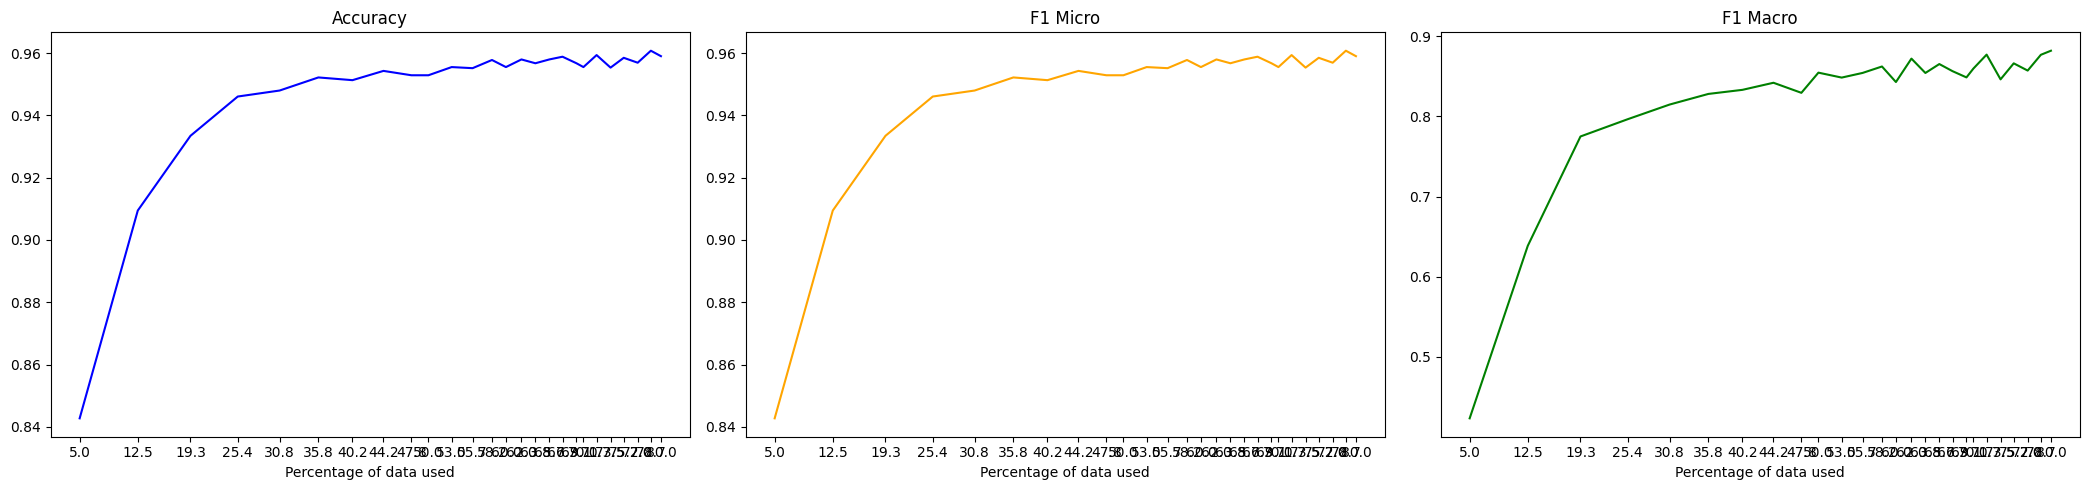

In [26]:
active_learning(seeds[4], 4)